<a href="https://colab.research.google.com/github/vrandezo/colabs/blob/master/Comparing_coverage_and_accuracy_of_DBpedia%2C_Freebase%2C_and_Wikidata_for_the_parent_predicate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparing coverage and accuracy of DBpedia, Freebase, and Wikidata for the parent predicate

Author: [Denny Vrandečić](https://www.wikidata.org/wiki/User:Denny), inviting co-authors

Wikidata, DBpedia, and Freebase are large knowledge bases that are all freely accessible. They work very differently and have very different histories. This notebook does not provide a comprehensive comparison of the three knowledge bases and their background, but rather looks into a single predicate and compares the coverage and accuracy of this predicate against each other. For a more comprehensive comparison, see the Section on Related Work.

All the steps for the comparisons are described in detail and should be reproducible. It should not only be possible to easily redo the given analysis for the chosen predicate, but also to extend it to other predicates. Since every use case will have slightly different requirements, it should be valuable to rerun the analysis as needed.

Note: the author of this comparison has been involved with creating Wikidata and shutting down Freebase. Thus, reader, be aware of possible bias (and that is also why I would very much appreciate other people to chime in and co-author).

The predicate chosen is parents. Why parents?
1. The parent predicate appears with a reasonable frequency in a general knowledge base.
2. It is unlikely that there is a single source or project or pipeline generating all parents, so the chance is higher that the results are representative.
3. All general knowledge bases should have a property or relation representing the parent predicate, or something very close to it (in fact, Wikidata does not have a parent property, but separate properties for mother and father - but that is easy to map).
4. There is a comparably high level of agreement on the extension of the parent predicate.
5. Both the domain and range of the parent predicate are simple entities with strong identities. Locations, genres, or literals like numbers, dates, or coordinates can often be subtly different without disagreeing: when one KB says that a person is born in Paris and another says that the person is born in France, both could be correct. Further analysis would be needed to account for this difference in granularity and precision. This is not the case for parents, which connects two individuals with each other.

This makes parent a rather simple and pragmatic first predicate to choose for this analysis.


# Datasets

We chose Wikidata, Freebase, and DBpedia as the generic knowledge bases to compare with each other. This section describes how we extracted the parent predicate from each of the three sources.

## Wikidata

We introduce three ways to access Wikidata data:

1. We can access Wikidata through the Wikidata MediaWiki API. For this see the function `o_from_sp` below. This is good for getting the values for a single entity and property pair, e.g. "*Who is the mother of Marie Curie?*"
2. We can access Wikidata's SPARQL endpoint. See the function `sparql_wikidata` and `list_of_entities_from_sparql` below. The queries can be more complex and cover a larger set of entities, also with complex descriptions, e.g. "*Who are parents of people who received Noble Prizes?*"
3. We can access the data through a Wikidata dump. This means we are not live querying Wikidata, but using the dump, which can be much faster as all computation is happening local. This is good for queries like "*Who are all the parents?*"

For 1. and 2., we access the data live from Wikidata. This ensures that the data is most current. For 3., this is not possible.

In [0]:
import json
from urllib.request import urlopen

def o_from_sp(qid, pid, quiet = False):
  url = 'https://www.wikidata.org/w/api.php?action=wbgetclaims&format=json&property=' + pid + '&entity=' + qid
  data = json.load(urlopen(url))
  if 'claims' not in data:
    if not quiet: print(qid, 'no claims', data)
    return []
  if pid not in data['claims']:
    return []
  if len(data['claims'][pid]) < 1:
    if not quiet: print(child, 'no', pid, data)
    return []
  vals = []
  for v in data['claims'][pid]:
    if 'mainsnak' not in v:
      if not quiet: print(child, 'no mainsnak', data, v)
      continue
    if 'datavalue' not in v['mainsnak']:
      if not quiet: print(child, 'no datavalue', data, v)
      continue
    if 'value' not in v['mainsnak']['datavalue']:
      if not quiet: print(child, 'no datavalue', data, v)
      continue
    if 'id' not in v['mainsnak']['datavalue']['value']:
      if not quiet: print(child, 'no value', data, v)
      continue
    vals += [v['mainsnak']['datavalue']['value']['id']]
  return vals

def get_wikidata_parents_from_api(qid, quiet = True):
  dad = o_from_sp(qid, 'P22', quiet)
  mom = o_from_sp(qid, 'P25', quiet)
  return mom + dad

def name_from_qid(qid, quiet = False):
  url = 'https://www.wikidata.org/w/api.php?action=wbgetentities&format=json&ids=' + qid + '&props=labels&languagefallback=&languages=en'
  data = json.load(urlopen(url))
  if 'entities' not in data:
    if not quiet: print(qid, 'no entities', data)
    return qid
  if qid not in data['entities']:
    return qid
  if 'labels' not in data['entities'][qid]:
    return qid
  if 'en' not in data['entities'][qid]['labels']:
    return qid
  if 'value' not in data['entities'][qid]['labels']['en']:
    return qid
  return data['entities'][qid]['labels']['en']['value']



In [2]:
print(o_from_sp('Q42', 'P25'))  # who is the mother of Douglas Adams
print(get_wikidata_parents_from_api('Q42'))
print(name_from_qid('Q42'))

['Q14623678']
['Q14623678', 'Q14623675']
Douglas Adams


In [0]:
import json
from urllib.parse import urlencode

def sparql_wikidata(query):
  url = 'https://query.wikidata.org/sparql?'
  params = urlencode({'format': 'json', 'query': query})
  results = json.load(urlopen(url + params))
  return results

def list_of_entities_from_sparql(query):
  results = sparql_wikidata(query)
  if 'results' not in results: return []
  if 'bindings' not in results['results']: return []
  vals = []
  for v in results['results']['bindings']:
    if 'entity' not in v: continue
    if 'type' not in v['entity']: continue
    if v['entity']['type'] != 'uri': continue
    if 'value' not in v['entity']: continue
    vals += [v['entity']['value'][31:]]
  return vals

def count_from_sparql(query):
  results = sparql_wikidata(query)
  if 'results' not in results: return -1
  if 'bindings' not in results['results']: return -1
  if len(results['results']['bindings']) != 1: return -1
  if 'count' not in results['results']['bindings'][0]: return -1
  if 'type' not in results['results']['bindings'][0]['count']: return -1
  if results['results']['bindings'][0]['count']['type'] != 'literal': return -1
  if 'datatype' not in results['results']['bindings'][0]['count']: return -1
  if results['results']['bindings'][0]['count']['datatype'] != 'http://www.w3.org/2001/XMLSchema#integer': return -1
  if 'value' not in results['results']['bindings'][0]['count']: return -1
  return int(results['results']['bindings'][0]['count']['value'])

In [4]:
query = 'select * { { wd:Q42 wdt:P25 ?entity } union { wd:Q42 wdt:P22 ?entity } }' # parents of Douglas Adams
print(list_of_entities_from_sparql(query))
query = 'select (count (?s) as ?count) where { { ?s wdt:P22 ?o } UNION { ?s wdt:P25 ?o } }'
print('{:,} parent relationships in Wikidata'.format(count_from_sparql(query)))

['Q14623678', 'Q14623675']
341,061 parent relationships in Wikidata


Option 3 allows us to speed things up considerably. But we cannot download the whole Wikidata dataset into a colab hosted environment, as it is 70 GB, and thus too big. We have prepared two slices, for P22 (father) and P25 (mother) and made them available for download. You can download the data with the following code.



In [0]:
import os
from urllib.request import urlretrieve

def download(url, file):
  if not os.path.isfile(file):
    print("Download file... " + file + " ...")
    urlretrieve(url, file)
    print("File downloaded")
  else:
    print("File already downloaded:", file)

In [8]:
download('http://simia.net/download/P22.nt.bz2', 'P22.nt.bz2')
download('http://simia.net/download/P25.nt.bz2', 'P25.nt.bz2')

Download file... P22.nt.bz2 ...
File downloaded
Download file... P25.nt.bz2 ...
File downloaded


Here we describe how we created the slices.

The Wikidata dataset can be downloaded from https://dumps.wikimedia.org/wikidatawiki/entities/

Store the following short script as `extract.py`:

```
import bz2
import sys

prop = '<http://www.wikidata.org/prop/direct/{}>'.format(sys.argv[1])

for line in bz2.open('latest-all.nt.bz2', 'r'):
s, p, o, rest = line.decode('utf-8').strip().split(' ', 3)
if p == prop:
  print(s, p, o, '.')
```
Then the slices can be generated by (P22 is father, P25 mother):

```
wget https://dumps.wikimedia.org/wikidatawiki/entities/latest-all.nt.bz2
python3 extract.py P22 > P22.nt
python3 extract.py P25 > P25.nt
bzip2 P22.nt
bzip2 P25.nt
```

The two resulting datafiles, ```P22.nt.bz2``` and ```P25.nt.bz2```, can then be uploaded to this colab.

The following short script loads them into RAM (whether the data has been uploaded from your machine or fetched from the data we provided) and extracts all parents, merging together fathers and mothers.

In [9]:
import bz2

wdparent = {}

def count_lines(prop):
  count = 0
  for line in bz2.open(prop + '.nt.bz2', 'r'):
    s, p, o, dot = line.decode('utf-8').strip().split()
    s = s[32:-1]
    o = o[32:-1]
    count += 1
    if s not in wdparent: wdparent[s] = []
    wdparent[s] += [o]
  return count

p22count = count_lines('P22')
p25count = count_lines('P25')

print('P22 has {:,} triples'.format(p22count))
print('P25 has {:,} triples'.format(p25count))
print('{:,} total parent relationships'.format(p22count + p25count))
print('{:,} children'.format(len(wdparent)))

P22 has 227,990 triples
P25 has 50,344 triples
278,334 total parent relationships
232,995 children


## Freebase

Freebase uses MIDs instead of Wikidata QIDs. Thus we will also need a mapping of MIDs to QIds. We download here the mapping that is available on the Freebase download Website at https://developers.google.com/freebase/

That mapping contains about 2 million mappings.

In [10]:
import gzip

download('http://storage.googleapis.com/freebase-public/fb2w.nt.gz', 'fb2w.nt.gz')

fbmappings = {}

for line in gzip.open('fb2w.nt.gz', 'r'):
  line = line.decode('utf-8').strip()
  if not line: continue
  if line[0] == '#': continue
  s, p, o = line.split('\t')
  fbmappings[s[28:-1]] = o[32:-3]

print('{:,} mappings'.format(len(fbmappings)))


Download file... fb2w.nt.gz ...
File downloaded
2,096,745 mappings


For Freebase itself, we take the latest dump of Freebase that was made before Freebase was shut down, and that is available from this Website: https://developers.google.com/freebase/

Similarly to Wikidata, the Freebase download with 30 GB is too big to be downloaded and processed in colab. So we created a slice that can be downloaded in the following.

In [11]:
download('http://simia.net/download/parents.nt.gz', 'parents.nt.gz')

Download file... parents.nt.gz ...
File downloaded


If you want to create the slice yourself, here is the code to do so. You need to run an extractor that takes out all the parent properties. The extractor script is given here:

```
import gzip

prop = '<http://rdf.freebase.com/ns/people.person.parents>'

for line in gzip.open('freebase-rdf-latest.gz', 'r'):
  s, p, o, rest = line.decode('utf-8').strip().split('\t', 3)
  if p == prop:
    print(s, p, o, rest)

```

If that is stored as ```fbextract.py```, the following commands will produce the necessary slice:

```
wget http://commondatastorage.googleapis.com/freebase-public/rdf/freebase-rdf-latest.gz
python3 fbextract.py > parents.nt
gzip parents.nt
```

The resulting file ```parents.nt.gz``` then can be uploaded to this Colab and can be loaded by running the following snippet.

In [12]:
def fbmap(mid):
  mid = mid[28:-1]
  if mid in fbmappings:
    return fbmappings[mid]
  return mid

fbparent = {}
triplecount = 0
mappedcount = 0
halfmappedcount = 0

for line in gzip.open('parents.nt.gz', 'r'):
  s, p, o, rest = line.decode('utf-8').strip().split()
  triplecount += 1
  s = fbmap(s)
  o = fbmap(o)
  if (s[0]=='Q') ^ (o[0]=='Q'): halfmappedcount += 1
  if s[0] != 'Q': continue
  if o[0] != 'Q': continue
  mappedcount += 1
  if s not in fbparent: fbparent[s] = []
  fbparent[s] += [o]

fbparentcount = triplecount
print('{:,} unmapped parent relationships'.format(triplecount))
print('{:,} half mapped parent relationships'.format(halfmappedcount))
print('{:,} fully mapped parent relationships'.format(mappedcount))
print('{:,} children'.format(len(fbparent)))


382,502 unmapped parent relationships
141,059 half mapped parent relationships
35,812 fully mapped parent relationships
27,369 children


## DBpedia

Unlike Wikidata and Freebase, DBpedia is a much more complex dataset. There is no such thing as a single DBpedia dataset that we can use. In fact, there are so called DBpedia chapters based on the local Wikipedias, and there are several dozens of those, each chapter featuring their own localized URIs for an entity and a different dataset. There is current work to evolve this situation in the next release of DBpedia, which is still under development.

In order to choose the best possible accuracy for DBpedia - understanding that this can be detrimental for coverage - we choose the Mappingbased dataset. The Mappingbased data is described by DBpedia as "*High-quality data extracted from Infoboxes using the mapping-based extraction*" and "*The Mapping-based Properties in the 'ontology' namespace, should always be preferred over this data.*" We follow DBpedias advice.

We choose the canoncial data. That data already maps to Wikidata QIDs. This further reduces coverage since not all entities are mapped. It can probably be safely assumed that all nonmapped triples would be wins for DBpedia coverage.

DBpedia is currently undergoing a massive rewrite. Because of that, their last stable release is a bit dated and dates from October 2016:

https://wiki.dbpedia.org/develop/datasets

https://wiki.dbpedia.org/develop/datasets/dbpedia-version-2016-10 

In the following, we download all mapping-based canonical datasets. The mappings exist for 39 chapters.


In [13]:
mapped_communities = ['ar', 'az', 'be', 'bg', 'bn', 'ca', 'cs', 'cy', 'de', 'el',
                      'en', 'eo', 'es', 'eu', 'fr', 'ga', 'gl', 'hi', 'hr', 'hu',
                      'hy', 'id', 'it', 'ja', 'ko', 'lv', 'mk', 'nl', 'pl', 'pt',
                      'ro', 'ru', 'sk', 'sl', 'sr', 'sv', 'tr', 'uk', 'vi']

import bz2

for lang in mapped_communities:
  print(lang)
  url = 'http://downloads.dbpedia.org/2016-10/core-i18n/' + lang + '/mappingbased_objects_wkd_uris_' + lang + '.ttl.bz2'
  filename = 'mappingbased_objects_wkd_uris_' + lang + '.ttl.bz2'
  download(url, filename)

ar
Download file... mappingbased_objects_wkd_uris_ar.ttl.bz2 ...
File downloaded
az
Download file... mappingbased_objects_wkd_uris_az.ttl.bz2 ...
File downloaded
be
Download file... mappingbased_objects_wkd_uris_be.ttl.bz2 ...
File downloaded
bg
Download file... mappingbased_objects_wkd_uris_bg.ttl.bz2 ...
File downloaded
bn
Download file... mappingbased_objects_wkd_uris_bn.ttl.bz2 ...
File downloaded
ca
Download file... mappingbased_objects_wkd_uris_ca.ttl.bz2 ...
File downloaded
cs
Download file... mappingbased_objects_wkd_uris_cs.ttl.bz2 ...
File downloaded
cy
Download file... mappingbased_objects_wkd_uris_cy.ttl.bz2 ...
File downloaded
de
Download file... mappingbased_objects_wkd_uris_de.ttl.bz2 ...
File downloaded
el
Download file... mappingbased_objects_wkd_uris_el.ttl.bz2 ...
File downloaded
en
Download file... mappingbased_objects_wkd_uris_en.ttl.bz2 ...
File downloaded
eo
Download file... mappingbased_objects_wkd_uris_eo.ttl.bz2 ...
File downloaded
es
Download file... mappingb

In the following we look at a few common stats of the download files - how many triples are there, how many properties, and what are the most common properties per file.

In [14]:
import operator

for lang in mapped_communities:
  filename = 'mappingbased_objects_wkd_uris_' + lang + '.ttl.bz2'
  triplecount = 0
  pcount = {}
  for line in bz2.open(filename, 'r'):
    line = line.decode('utf-8').strip()
    if line[0] == '#': continue
    triplecount += 1
    s, p, o, dot = line.split()
    if p not in pcount: pcount[p] = 0
    pcount[p] += 1
  print(lang)
  print('{:,} triples'.format(triplecount))
  print('{:,} properties'.format(len(pcount)))
  print('Top five properties:')
  for p in sorted(pcount.items(), reverse = True, key = lambda kv: kv[1])[:5]:
    print('{:>8,} {}'.format(p[1], p[0][1:-1]))
  print()

ar
169,350 triples
170 properties
Top five properties:
  27,820 http://dbpedia.org/ontology/timeZone
  25,295 http://dbpedia.org/ontology/birthPlace
  11,914 http://dbpedia.org/ontology/starring
  11,768 http://xmlns.com/foaf/0.1/homepage
  10,807 http://dbpedia.org/ontology/deathPlace

az
18,628 triples
21 properties
Top five properties:
   9,341 http://dbpedia.org/ontology/birthPlace
   4,939 http://dbpedia.org/ontology/deathPlace
   1,253 http://dbpedia.org/ontology/occupation
     816 http://xmlns.com/foaf/0.1/homepage
     597 http://dbpedia.org/ontology/genre

be
71,330 triples
115 properties
Top five properties:
   8,584 http://dbpedia.org/ontology/birthPlace
   8,364 http://xmlns.com/foaf/0.1/homepage
   4,781 http://dbpedia.org/ontology/region
   3,776 http://dbpedia.org/ontology/country
   3,284 http://dbpedia.org/ontology/deathPlace

bg
428,733 triples
167 properties
Top five properties:
  68,160 http://dbpedia.org/ontology/birthPlace
  33,828 http://dbpedia.org/ontology/dea

Now we load the parent relationships.

When looking at the results, it is easy to see that the Italian chapter will be problematic as there are on average more than two parents per person.

In [15]:
dbparent = {}

for lang in mapped_communities:
  dbparent[lang] = {}
  parentcount = 0
  filename = 'mappingbased_objects_wkd_uris_' + lang + '.ttl.bz2'
  for line in bz2.open(filename, 'r'):
    line = line.decode('utf-8').strip()
    if line[0] == '#': continue
    s, p, o, dot = line.split()
    # Note that in the English chapter, a different namespace is used.
    # The following works for all chapters
    if not p.endswith('dbpedia.org/ontology/parent>'): continue
    s = s[38:-1]
    o = o[38:-1]
    if s not in dbparent[lang]: dbparent[lang][s] = []
    dbparent[lang][s] += [o]
    parentcount += 1
  print(lang)
  print('{:,} parent relationships'.format(parentcount))
  print('{:,} children'.format(len(dbparent[lang])))
  print()

ar
42 parent relationships
37 children

az
181 parent relationships
166 children

be
1,195 parent relationships
1,035 children

bg
1,674 parent relationships
1,114 children

bn
55 parent relationships
46 children

ca
0 parent relationships
0 children

cs
466 parent relationships
330 children

cy
7 parent relationships
7 children

de
0 parent relationships
0 children

el
947 parent relationships
756 children

en
23,558 parent relationships
17,467 children

eo
0 parent relationships
0 children

es
7,453 parent relationships
4,946 children

eu
0 parent relationships
0 children

fr
5,168 parent relationships
3,903 children

ga
0 parent relationships
0 children

gl
0 parent relationships
0 children

hi
0 parent relationships
0 children

hr
427 parent relationships
425 children

hu
2,710 parent relationships
1,949 children

hy
0 parent relationships
0 children

id
426 parent relationships
376 children

it
7,885 parent relationships
2,766 children

ja
8,214 parent relationships
6,687 children

## DBpedia Fusion (beta)

The current beta of the DBpedia Fusion dataset is available on the DBpedia Databus website:

https://databus.dbpedia.org/

The databus data is still in beta. Particularly it does not include the cleaning process based on the domain and range yet (which turns out to be rather noticeable).

Instead of using the individual chapters, as before, we load the Fusion dataset. The Fusion dataset integrates 140 Wikipedias and Wikidata, and thus is far larger than any of the individual chapters. Also, the DBpedia community is concentrating their effort into the further development of the Fusion dataset, so it is assumed that this is their most comprehensive dataset. As it also contains Wikidata, the Fusion dataset should improve in coverage over Wikidata.

The new releases also do not canonicalize to Wikidata anymore, but introduce a new opaque DBpedia identifier system. In the following, we download the mappings from Wikidata IDs to DBpedia identifiers.

The mappings of DBpedia URIs to Wikidata's identifiers can be obtained from https://databus.dbpedia.org/dbpedia/id-management/global-ids 


In [16]:
download('https://downloads.dbpedia.org/repo/lts/id-management/global-ids/2019.02.28/global-ids_base58.tsv.bz2', 'global-ids_base58.tsv.bz2')

fusionmappings = {}

linecount = 0
for line in bz2.open('global-ids_base58.tsv.bz2', 'r'):
  source, local, dbid = line.decode('utf-8').strip().split('\t')
  linecount += 1
  if source.startswith('http://www.wikidata.org/entity/Q'):
    fusionmappings[dbid] = source[31:]

print('{:,} Wikidata mappings'.format(len(fusionmappings)))
print('{:,} mappings in total'.format(linecount))

Download file... global-ids_base58.tsv.bz2 ...
File downloaded
46,291,802 Wikidata mappings
92,404,350 mappings in total


With the mappings loaded, we can now load and map the parent relationships from the Fusion dataset.

In [17]:
import bz2

download('https://downloads.dbpedia.org/repo/lts/fusion/mappingbased-objects-uncleaned/2019.03.01/mappingbased-objects-uncleaned_reduce=dbpw_resolve=preference.ttl.bz2', 'mappingbased-objects-uncleaned-fusion.ttl.bz2')

fuseparent = {}

triplecount = 0
parentcount = 0
halfmappedcount = 0
mappedparentcount = 0
pcount = {}

def fusemap(dbid):
  if not dbid.startswith('<https://global.dbpedia.org/id/'): return dbid
  cut = dbid[31:dbid.find('>')]
  if cut in fusionmappings:
    return fusionmappings[cut]
  return dbid

for line in bz2.open('mappingbased-objects-uncleaned-fusion.ttl.bz2', 'r'):
  line = line.decode('utf-8').strip()
  if line[0] == '#': continue
  triplecount += 1
  s, p, o = line.split(' ', 2)
  if p not in pcount: pcount[p] = 0
  pcount[p] += 1
  if p == '<http://dbpedia.org/ontology/parent>':
    parentcount += 1
    s = fusemap(s)
    o = fusemap(o)
    if (s[0]=='Q') ^ (o[0]=='Q'): halfmappedcount += 1
    if s[0] != 'Q': continue
    if o[0] != 'Q': continue
    mappedparentcount += 1
    if s not in fuseparent: fuseparent[s] = []
    fuseparent[s] += [o]

fuseparentcount = parentcount

print('{:,} triples'.format(triplecount))
print('{:,} properties'.format(len(pcount)))
print('{:,} parent relationships total (including unmapped)'.format(parentcount))
print('{:,} halfmapped parent relationships'.format(halfmappedcount))
print('{:,} mapped parent relationships'.format(mappedparentcount))
print('{:,} children'.format(len(fuseparent)))
print('Top five properties:')
for p in sorted(pcount.items(), reverse = True, key = lambda kv: kv[1])[:5]:
  print('{:>8,} {}'.format(p[1], p[0][1:-1]))


Download file... mappingbased-objects-uncleaned-fusion.ttl.bz2 ...
File downloaded
131,482,132 triples
1,030 properties
49,663 parent relationships total (including unmapped)
14,930 halfmapped parent relationships
32,075 mapped parent relationships
32,075 children
Top five properties:
56,178,087 http://www.w3.org/2000/01/rdf-schema#seeAlso
10,973,303 http://dbpedia.org/ontology/country
6,666,890 http://dbpedia.org/ontology/city
3,473,219 http://dbpedia.org/ontology/occupation
2,877,897 http://dbpedia.org/ontology/citizenship


# Coverage
In this section we calculate the difference in coverage between the different datasets.

## DBpedia chapters and Wikidata
In order to increase the fairness of the comparison, we compare in this subsection how many parent relationships are in Wikidata for the people that actually have an article in the given Wikipedia, and how many parent relationships are extracted by a given DBpedia chapter.

For comparing with the DBpedia chapters we get numbers for Wikidata coverage directly from the live SPARQL endpoint, because this makes it easier to find which people have Wikipedia articles in the given language.

ar
25,457 parent relationships in Wikidata for given language
42 parent relationships in DBpedia chapter
23 agreements (0.1%)
17 DBpedia wins (0.1%)
25,432 Wikidata wins (99.8%)
8 Wikidata wins on DBpedia people (0.0%)
2 DBpedia disagreements (0.0%)
2 Wikidata disagreements (0.0%)
4 disagreements (0.0%)
25,472 total parent relationships


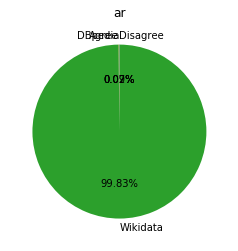

az
5,664 parent relationships in Wikidata for given language
181 parent relationships in DBpedia chapter
72 agreements (1.2%)
107 DBpedia wins (1.9%)
5,588 Wikidata wins (96.9%)
27 Wikidata wins on DBpedia people (0.5%)
2 DBpedia disagreements (0.0%)
4 Wikidata disagreements (0.1%)
6 disagreements (0.1%)
5,767 total parent relationships


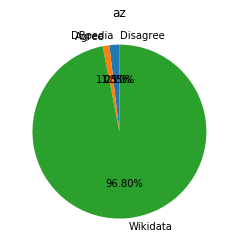

be
9,371 parent relationships in Wikidata for given language
1,195 parent relationships in DBpedia chapter
1,089 agreements (11.7%)
48 DBpedia wins (0.5%)
8,208 Wikidata wins (87.8%)
578 Wikidata wins on DBpedia people (6.2%)
58 DBpedia disagreements (0.6%)
74 Wikidata disagreements (0.8%)
132 disagreements (1.4%)
9,345 total parent relationships


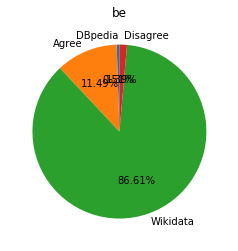

bg
24,782 parent relationships in Wikidata for given language
1,674 parent relationships in DBpedia chapter
1,523 agreements (6.2%)
55 DBpedia wins (0.2%)
23,133 Wikidata wins (93.6%)
432 Wikidata wins on DBpedia people (1.7%)
96 DBpedia disagreements (0.4%)
126 Wikidata disagreements (0.5%)
222 disagreements (0.9%)
24,711 total parent relationships


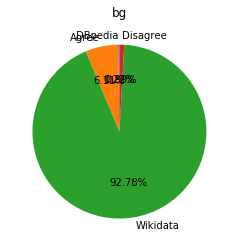

bn
4,053 parent relationships in Wikidata for given language
55 parent relationships in DBpedia chapter
47 agreements (1.2%)
6 DBpedia wins (0.1%)
4,003 Wikidata wins (98.7%)
21 Wikidata wins on DBpedia people (0.5%)
2 DBpedia disagreements (0.0%)
3 Wikidata disagreements (0.1%)
5 disagreements (0.1%)
4,056 total parent relationships


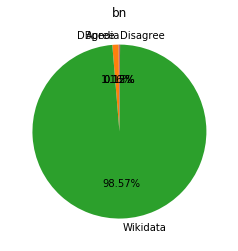

ca
29,043 parent relationships in Wikidata for given language
0 parent relationships in DBpedia chapter
0 agreements (0.0%)
0 DBpedia wins (0.0%)
29,043 Wikidata wins (100.0%)
0 Wikidata wins on DBpedia people (0.0%)
0 DBpedia disagreements (0.0%)
0 Wikidata disagreements (0.0%)
0 disagreements (0.0%)
29,043 total parent relationships


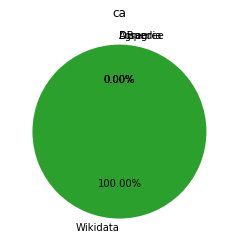

cs
22,701 parent relationships in Wikidata for given language
466 parent relationships in DBpedia chapter
398 agreements (1.7%)
62 DBpedia wins (0.3%)
22,298 Wikidata wins (98.0%)
62 Wikidata wins on DBpedia people (0.3%)
6 DBpedia disagreements (0.0%)
5 Wikidata disagreements (0.0%)
11 disagreements (0.0%)
22,758 total parent relationships


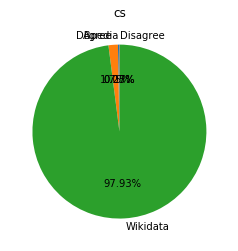

cy
5,244 parent relationships in Wikidata for given language
7 parent relationships in DBpedia chapter
6 agreements (0.1%)
1 DBpedia wins (0.0%)
5,238 Wikidata wins (99.9%)
3 Wikidata wins on DBpedia people (0.1%)
0 DBpedia disagreements (0.0%)
0 Wikidata disagreements (0.0%)
0 disagreements (0.0%)
5,245 total parent relationships


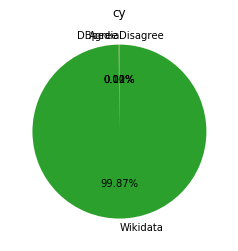

de
60,636 parent relationships in Wikidata for given language
0 parent relationships in DBpedia chapter
0 agreements (0.0%)
0 DBpedia wins (0.0%)
60,636 Wikidata wins (100.0%)
0 Wikidata wins on DBpedia people (0.0%)
0 DBpedia disagreements (0.0%)
0 Wikidata disagreements (0.0%)
0 disagreements (0.0%)
60,636 total parent relationships


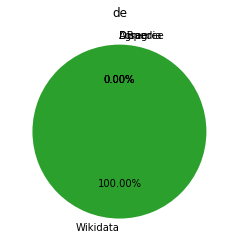

el
22,900 parent relationships in Wikidata for given language
947 parent relationships in DBpedia chapter
906 agreements (4.0%)
16 DBpedia wins (0.1%)
21,958 Wikidata wins (96.0%)
486 Wikidata wins on DBpedia people (2.1%)
25 DBpedia disagreements (0.1%)
36 Wikidata disagreements (0.2%)
61 disagreements (0.3%)
22,880 total parent relationships


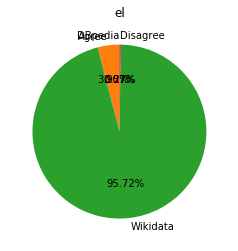

en
107,423 parent relationships in Wikidata for given language
23,558 parent relationships in DBpedia chapter
21,948 agreements (20.3%)
1,279 DBpedia wins (1.2%)
85,079 Wikidata wins (78.6%)
3,966 Wikidata wins on DBpedia people (3.7%)
331 DBpedia disagreements (0.3%)
396 Wikidata disagreements (0.4%)
727 disagreements (0.7%)
108,306 total parent relationships


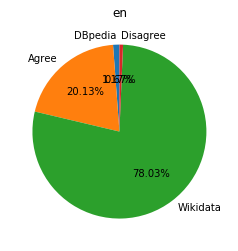

eo
11,099 parent relationships in Wikidata for given language
0 parent relationships in DBpedia chapter
0 agreements (0.0%)
0 DBpedia wins (0.0%)
11,099 Wikidata wins (100.0%)
0 Wikidata wins on DBpedia people (0.0%)
0 DBpedia disagreements (0.0%)
0 Wikidata disagreements (0.0%)
0 disagreements (0.0%)
11,099 total parent relationships


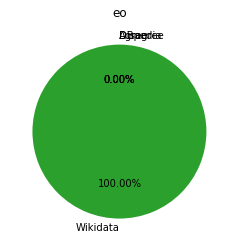

es
45,447 parent relationships in Wikidata for given language
7,453 parent relationships in DBpedia chapter
6,712 agreements (14.7%)
533 DBpedia wins (1.2%)
38,492 Wikidata wins (84.2%)
1,271 Wikidata wins on DBpedia people (2.8%)
208 DBpedia disagreements (0.5%)
243 Wikidata disagreements (0.5%)
451 disagreements (1.0%)
45,737 total parent relationships


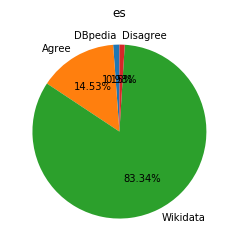

eu
10,101 parent relationships in Wikidata for given language
0 parent relationships in DBpedia chapter
0 agreements (0.0%)
0 DBpedia wins (0.0%)
10,101 Wikidata wins (100.0%)
0 Wikidata wins on DBpedia people (0.0%)
0 DBpedia disagreements (0.0%)
0 Wikidata disagreements (0.0%)
0 disagreements (0.0%)
10,101 total parent relationships


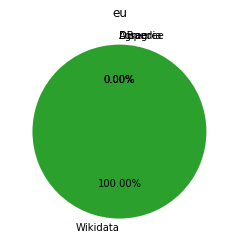

fr
68,116 parent relationships in Wikidata for given language
5,168 parent relationships in DBpedia chapter
4,660 agreements (6.8%)
353 DBpedia wins (0.5%)
63,287 Wikidata wins (92.7%)
1,199 Wikidata wins on DBpedia people (1.8%)
155 DBpedia disagreements (0.2%)
169 Wikidata disagreements (0.2%)
324 disagreements (0.5%)
68,300 total parent relationships


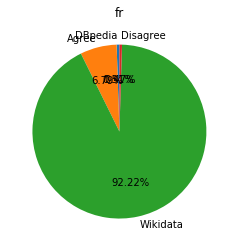

ga
2,851 parent relationships in Wikidata for given language
0 parent relationships in DBpedia chapter
0 agreements (0.0%)
0 DBpedia wins (0.0%)
2,851 Wikidata wins (100.0%)
0 Wikidata wins on DBpedia people (0.0%)
0 DBpedia disagreements (0.0%)
0 Wikidata disagreements (0.0%)
0 disagreements (0.0%)
2,851 total parent relationships


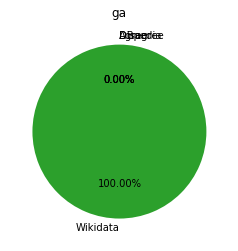

gl
7,976 parent relationships in Wikidata for given language
0 parent relationships in DBpedia chapter
0 agreements (0.0%)
0 DBpedia wins (0.0%)
7,976 Wikidata wins (100.0%)
0 Wikidata wins on DBpedia people (0.0%)
0 DBpedia disagreements (0.0%)
0 Wikidata disagreements (0.0%)
0 disagreements (0.0%)
7,976 total parent relationships


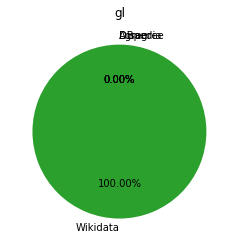

hi
3,610 parent relationships in Wikidata for given language
0 parent relationships in DBpedia chapter
0 agreements (0.0%)
0 DBpedia wins (0.0%)
3,610 Wikidata wins (100.0%)
0 Wikidata wins on DBpedia people (0.0%)
0 DBpedia disagreements (0.0%)
0 Wikidata disagreements (0.0%)
0 disagreements (0.0%)
3,610 total parent relationships


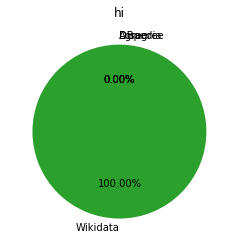

hr
8,589 parent relationships in Wikidata for given language
427 parent relationships in DBpedia chapter
349 agreements (4.0%)
59 DBpedia wins (0.7%)
8,211 Wikidata wins (95.3%)
261 Wikidata wins on DBpedia people (3.0%)
19 DBpedia disagreements (0.2%)
29 Wikidata disagreements (0.3%)
48 disagreements (0.6%)
8,619 total parent relationships


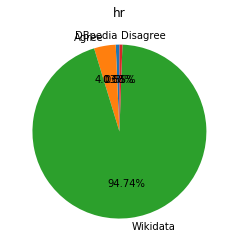

hu
18,051 parent relationships in Wikidata for given language
2,710 parent relationships in DBpedia chapter
2,489 agreements (13.7%)
157 DBpedia wins (0.9%)
15,473 Wikidata wins (85.4%)
730 Wikidata wins on DBpedia people (4.0%)
64 DBpedia disagreements (0.4%)
89 Wikidata disagreements (0.5%)
153 disagreements (0.8%)
18,119 total parent relationships


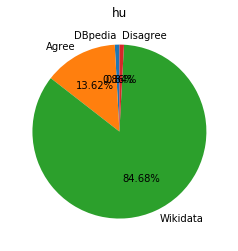

hy
7,956 parent relationships in Wikidata for given language
0 parent relationships in DBpedia chapter
0 agreements (0.0%)
0 DBpedia wins (0.0%)
7,956 Wikidata wins (100.0%)
0 Wikidata wins on DBpedia people (0.0%)
0 DBpedia disagreements (0.0%)
0 Wikidata disagreements (0.0%)
0 disagreements (0.0%)
7,956 total parent relationships


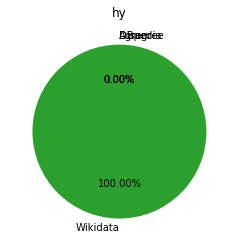

id
16,860 parent relationships in Wikidata for given language
426 parent relationships in DBpedia chapter
122 agreements (0.7%)
296 DBpedia wins (1.7%)
16,727 Wikidata wins (97.6%)
48 Wikidata wins on DBpedia people (0.3%)
8 DBpedia disagreements (0.0%)
11 Wikidata disagreements (0.1%)
19 disagreements (0.1%)
17,145 total parent relationships


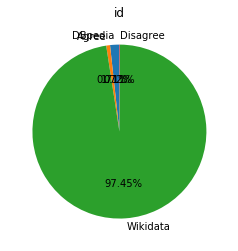

it
48,925 parent relationships in Wikidata for given language
7,885 parent relationships in DBpedia chapter
497 agreements (0.9%)
6,678 DBpedia wins (12.1%)
48,112 Wikidata wins (87.0%)
13 Wikidata wins on DBpedia people (0.0%)
710 DBpedia disagreements (1.3%)
316 Wikidata disagreements (0.6%)
1,026 disagreements (1.9%)
55,287 total parent relationships


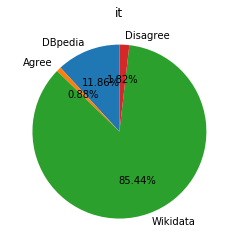

ja
41,747 parent relationships in Wikidata for given language
8,214 parent relationships in DBpedia chapter
3,292 agreements (7.1%)
4,831 DBpedia wins (10.4%)
38,366 Wikidata wins (82.5%)
248 Wikidata wins on DBpedia people (0.5%)
91 DBpedia disagreements (0.2%)
89 Wikidata disagreements (0.2%)
180 disagreements (0.4%)
46,489 total parent relationships


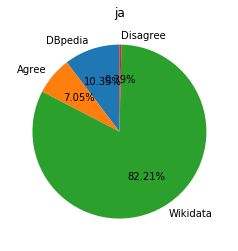

ko
19,764 parent relationships in Wikidata for given language
1,239 parent relationships in DBpedia chapter
841 agreements (4.2%)
363 DBpedia wins (1.8%)
18,879 Wikidata wins (94.0%)
327 Wikidata wins on DBpedia people (1.6%)
35 DBpedia disagreements (0.2%)
44 Wikidata disagreements (0.2%)
79 disagreements (0.4%)
20,083 total parent relationships


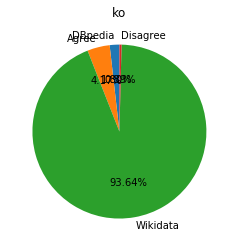

lv
4,965 parent relationships in Wikidata for given language
90 parent relationships in DBpedia chapter
52 agreements (1.0%)
35 DBpedia wins (0.7%)
4,910 Wikidata wins (98.3%)
23 Wikidata wins on DBpedia people (0.5%)
3 DBpedia disagreements (0.1%)
3 Wikidata disagreements (0.1%)
6 disagreements (0.1%)
4,997 total parent relationships


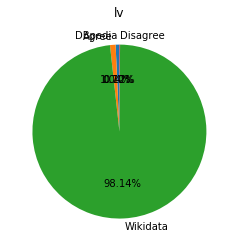

mk
4,320 parent relationships in Wikidata for given language
333 parent relationships in DBpedia chapter
325 agreements (7.5%)
2 DBpedia wins (0.0%)
3,986 Wikidata wins (92.4%)
196 Wikidata wins on DBpedia people (4.5%)
6 DBpedia disagreements (0.1%)
9 Wikidata disagreements (0.2%)
15 disagreements (0.3%)
4,313 total parent relationships


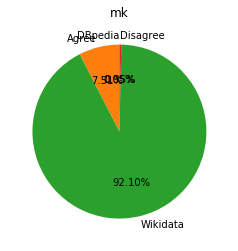

nl
34,147 parent relationships in Wikidata for given language
3,856 parent relationships in DBpedia chapter
3,642 agreements (10.7%)
86 DBpedia wins (0.3%)
30,310 Wikidata wins (89.0%)
1,233 Wikidata wins on DBpedia people (3.6%)
128 DBpedia disagreements (0.4%)
195 Wikidata disagreements (0.6%)
323 disagreements (0.9%)
34,038 total parent relationships


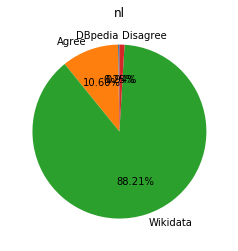

pl
38,271 parent relationships in Wikidata for given language
0 parent relationships in DBpedia chapter
0 agreements (0.0%)
0 DBpedia wins (0.0%)
38,271 Wikidata wins (100.0%)
0 Wikidata wins on DBpedia people (0.0%)
0 DBpedia disagreements (0.0%)
0 Wikidata disagreements (0.0%)
0 disagreements (0.0%)
38,271 total parent relationships


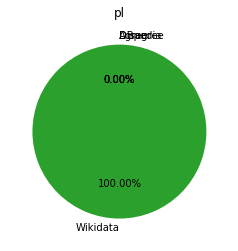

pt
33,150 parent relationships in Wikidata for given language
2,289 parent relationships in DBpedia chapter
1,945 agreements (5.8%)
271 DBpedia wins (0.8%)
31,110 Wikidata wins (93.4%)
534 Wikidata wins on DBpedia people (1.6%)
73 DBpedia disagreements (0.2%)
95 Wikidata disagreements (0.3%)
168 disagreements (0.5%)
33,326 total parent relationships


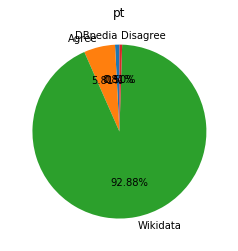

ro
14,417 parent relationships in Wikidata for given language
1 parent relationships in DBpedia chapter
0 agreements (0.0%)
1 DBpedia wins (0.0%)
14,417 Wikidata wins (100.0%)
0 Wikidata wins on DBpedia people (0.0%)
0 DBpedia disagreements (0.0%)
0 Wikidata disagreements (0.0%)
0 disagreements (0.0%)
14,418 total parent relationships


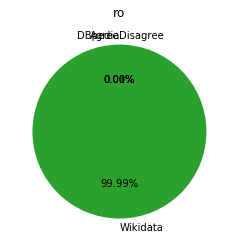

ru
55,570 parent relationships in Wikidata for given language
13,138 parent relationships in DBpedia chapter
12,153 agreements (21.9%)
523 DBpedia wins (0.9%)
42,887 Wikidata wins (77.2%)
2,795 Wikidata wins on DBpedia people (5.0%)
462 DBpedia disagreements (0.8%)
530 Wikidata disagreements (1.0%)
992 disagreements (1.8%)
55,563 total parent relationships


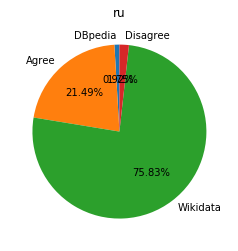

sk
8,059 parent relationships in Wikidata for given language
0 parent relationships in DBpedia chapter
0 agreements (0.0%)
0 DBpedia wins (0.0%)
8,059 Wikidata wins (100.0%)
0 Wikidata wins on DBpedia people (0.0%)
0 DBpedia disagreements (0.0%)
0 Wikidata disagreements (0.0%)
0 disagreements (0.0%)
8,059 total parent relationships


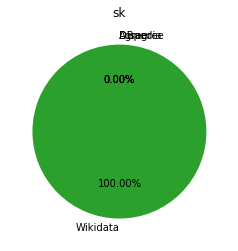

sl
6,195 parent relationships in Wikidata for given language
320 parent relationships in DBpedia chapter
219 agreements (3.5%)
86 DBpedia wins (1.4%)
5,958 Wikidata wins (95.1%)
125 Wikidata wins on DBpedia people (2.0%)
15 DBpedia disagreements (0.2%)
18 Wikidata disagreements (0.3%)
33 disagreements (0.5%)
6,263 total parent relationships


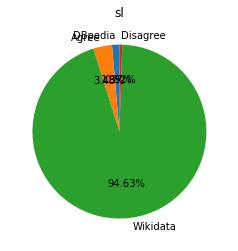

sr
11,578 parent relationships in Wikidata for given language
0 parent relationships in DBpedia chapter
0 agreements (0.0%)
0 DBpedia wins (0.0%)
11,578 Wikidata wins (100.0%)
0 Wikidata wins on DBpedia people (0.0%)
0 DBpedia disagreements (0.0%)
0 Wikidata disagreements (0.0%)
0 disagreements (0.0%)
11,578 total parent relationships


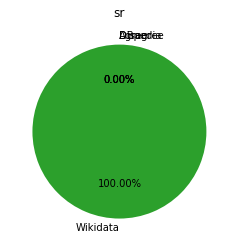

sv
34,501 parent relationships in Wikidata for given language
618 parent relationships in DBpedia chapter
375 agreements (1.1%)
237 DBpedia wins (0.7%)
34,121 Wikidata wins (98.2%)
41 Wikidata wins on DBpedia people (0.1%)
6 DBpedia disagreements (0.0%)
5 Wikidata disagreements (0.0%)
11 disagreements (0.0%)
34,733 total parent relationships


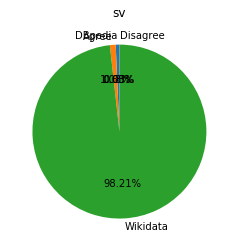

tr
12,083 parent relationships in Wikidata for given language
259 parent relationships in DBpedia chapter
141 agreements (1.2%)
105 DBpedia wins (0.9%)
11,925 Wikidata wins (98.0%)
47 Wikidata wins on DBpedia people (0.4%)
13 DBpedia disagreements (0.1%)
17 Wikidata disagreements (0.1%)
30 disagreements (0.2%)
12,171 total parent relationships


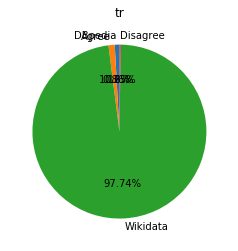

uk
28,352 parent relationships in Wikidata for given language
562 parent relationships in DBpedia chapter
482 agreements (1.7%)
60 DBpedia wins (0.2%)
27,844 Wikidata wins (98.1%)
250 Wikidata wins on DBpedia people (0.9%)
20 DBpedia disagreements (0.1%)
26 Wikidata disagreements (0.1%)
46 disagreements (0.2%)
28,386 total parent relationships


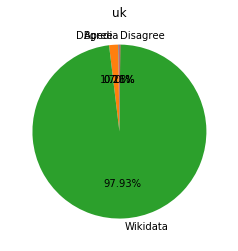

vi
12,384 parent relationships in Wikidata for given language
3 parent relationships in DBpedia chapter
0 agreements (0.0%)
3 DBpedia wins (0.0%)
12,384 Wikidata wins (100.0%)
0 Wikidata wins on DBpedia people (0.0%)
0 DBpedia disagreements (0.0%)
0 Wikidata disagreements (0.0%)
0 disagreements (0.0%)
12,387 total parent relationships


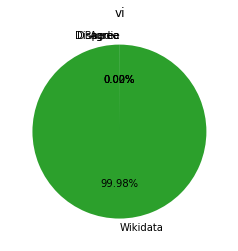

In [18]:
import matplotlib.pyplot as plt

dbdisagreementsperlang = {}
dbwinsperlang = {}

def coverage_chapter(lang):
  query = """select (count(?s) as ?count) where {
    ?article schema:about ?s .
    ?article schema:isPartOf <https://""" + lang + """.wikipedia.org/> .
    { ?s wdt:P22 ?o } union { ?s wdt:P25 ?o }
  }"""
  print(lang)
  wdcount = count_from_sparql(query)
  print('{:,} parent relationships in Wikidata for given language'.format(wdcount))
  dbcount = sum(len(dbparent[lang][parents]) for parents in dbparent[lang])
  print('{:,} parent relationships in DBpedia chapter'.format(dbcount))

  agreed = 0
  dbdisagreed = 0
  wddisagreed = 0
  dbwin = 0
  wdwincontrast = 0

  for child in dbparent[lang]:
    dbparents = dbparent[lang][child][:]
    wdparents = []
    if child in wdparent: wdparents = wdparent[child][:]

    for parent in dbparents + wdparents:
      if parent in dbparents and parent in wdparents:
        dbparents.remove(parent)
        wdparents.remove(parent)
        agreed += 1
    if dbparents and wdparents:
      dbdisagreed += len(dbparents)
      wddisagreed += len(wdparents)
      continue
    if dbparents:
      dbwin += len(dbparents)
    if wdparents:
      wdwincontrast += len(wdparents)

  total = wdcount + dbcount - (dbdisagreed + wddisagreed + agreed)
  wdwin = wdcount - (wddisagreed + agreed)

  print('{:,} agreements ({:.1%})'.format(agreed, agreed/total))
  print('{:,} DBpedia wins ({:.1%})'.format(dbwin, dbwin/total))
  print('{:,} Wikidata wins ({:.1%})'.format(wdwin, wdwin/total))
  print('{:,} Wikidata wins on DBpedia people ({:.1%})'.format(wdwincontrast, wdwincontrast/total))
  print('{:,} DBpedia disagreements ({:.1%})'.format(dbdisagreed, dbdisagreed/total))
  print('{:,} Wikidata disagreements ({:.1%})'.format(wddisagreed, wddisagreed/total))
  print('{:,} disagreements ({:.1%})'.format(dbdisagreed + wddisagreed, (dbdisagreed + wddisagreed)/total))
  print('{:,} total parent relationships'.format(total))

  labels = 'DBpedia', 'Agree', 'Wikidata', 'Disagree'
  sections = dbwin, agreed, wdwin, dbdisagreed + wddisagreed

  dbdisagreementsperlang[lang] = dbdisagreed + wddisagreed
  dbwinsperlang[lang] = dbwin

  plt.pie(sections, labels = labels, autopct = '%1.2f%%', startangle= 90)
  plt.title(lang)
  plt.show()
  
for lang in mapped_communities:
  coverage_chapter(lang)


In all languages but Italian (it) and Japanese (ja) Wikidata achieves a coverage of over 97%. In Italian, the coverage is 86% (but note that it contains many errors, as we will see in the Section "Accuracy"), and in Japanese 88%.

There are a number of languages that provide such a small difference that it would be easy to just go through them and either integrate them in Wikidata, or reject them as being wrong.

For the chapters that have larger differences, a more coordinated approach might be useful.

Total number of disagreements


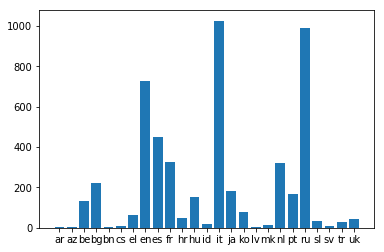

Total number of new data


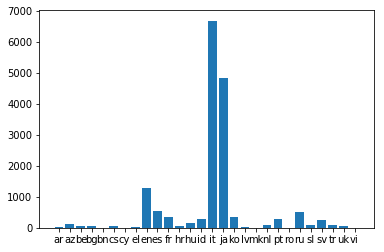

In [19]:
def show_barchart(n):
  m = { k:v for k,v in n.items() if v }
  plt.bar(m.keys(), m.values())
  plt.plot()
  plt.show()

print('Total number of disagreements')
show_barchart(dbdisagreementsperlang)

print('Total number of new data')
show_barchart(dbwinsperlang)

## DBpedia Fusion and Wikidata

Here we compare the DBpedia Fusion dataset with the Wikidata dataset.

278,334 parent relationships in Wikidata
49,663 parent relationships in DBpedia
24,998 agreements (8.3%)
23,489 DBpedia wins (7.8%)
5,901 DBpedia wins on Wikidata people (2.0%)
251,835 Wikidata wins (83.9%)
11,760 Wikidata wins on DBpedia people (3.9%)
1,176 DBpedia disagreements (0.4%)
1,501 Wikidata disagreements (0.5%)
2,677 disagreements (0.9%)
300,322 total parent relationships


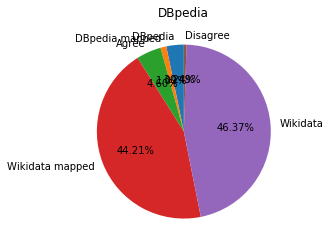

In [20]:
import matplotlib.pyplot as plt

def coverage_fusion():
  wdcount = sum(len(wdparent[parents]) for parents in wdparent)
  print('{:,} parent relationships in Wikidata'.format(wdcount))
  print('{:,} parent relationships in DBpedia'.format(fuseparentcount))

  agreed = 0
  dbdisagreed = 0
  wddisagreed = 0
  dbwincontrast = 0
  wdwincontrast = 0

  for child in fuseparent:
    dbparents = fuseparent[child][:]
    wdparents = []
    if child in wdparent: wdparents = wdparent[child][:]

    for parent in dbparents + wdparents:
      if parent in dbparents and parent in wdparents:
        dbparents.remove(parent)
        wdparents.remove(parent)
        agreed += 1
    if dbparents and wdparents:
      dbdisagreed += len(dbparents)
      wddisagreed += len(wdparents)
      continue
    if dbparents:
      dbwincontrast += len(dbparents)
    if wdparents:
      wdwincontrast += len(wdparents)

  total = wdcount + fuseparentcount - (dbdisagreed + wddisagreed + agreed)
  wdwin = wdcount - (wddisagreed + agreed)
  dbwin = fuseparentcount - (dbdisagreed + agreed)

  print('{:,} agreements ({:.1%})'.format(agreed, agreed/total))
  print('{:,} DBpedia wins ({:.1%})'.format(dbwin, dbwin/total))
  print('{:,} DBpedia wins on Wikidata people ({:.1%})'.format(dbwincontrast, dbwincontrast/total))
  print('{:,} Wikidata wins ({:.1%})'.format(wdwin, wdwin/total))
  print('{:,} Wikidata wins on DBpedia people ({:.1%})'.format(wdwincontrast, wdwincontrast/total))
  print('{:,} DBpedia disagreements ({:.1%})'.format(dbdisagreed, dbdisagreed/total))
  print('{:,} Wikidata disagreements ({:.1%})'.format(wddisagreed, wddisagreed/total))
  print('{:,} disagreements ({:.1%})'.format(dbdisagreed + wddisagreed, (dbdisagreed + wddisagreed)/total))
  print('{:,} total parent relationships'.format(total))

  labels = 'DBpedia', 'DBpedia mapped', 'Agree', 'Wikidata mapped', 'Wikidata', 'Disagree'
  sections = dbwin-dbwincontrast, dbwincontrast, agreed, wdwin-wdwincontrast, wdwin, dbdisagreed + wddisagreed

  plt.pie(sections, labels = labels, autopct = '%1.2f%%', startangle= 90)
  plt.title('DBpedia')
  plt.show()
  
coverage_fusion()


This is surprising: since the Fusion dataset includes Wikidata, a much larger agreement should be expected.

/todo(vrandecic): Huh? Looks wrong. Sebastian, any ideas? Is it maybe just the timing of the datasets?

## Freebase and Wikidata

Here we compare the Freebase dataset with the Wikidata dataset.

278,334 parent relationships in Wikidata
382,502 parent relationships in Freebase
31,304 agreements (5.0%)
350,678 Freebase wins (55.8%)
3,988 Freebase wins on Wikidata people (0.6%)
246,431 Wikidata wins (39.2%)
5,166 Wikidata wins on DBpedia people (0.8%)
520 Freebase disagreements (0.1%)
599 Wikidata disagreements (0.1%)
1,119 disagreements (0.2%)
628,413 total parent relationships


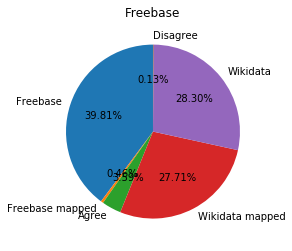

In [21]:
import matplotlib.pyplot as plt

def coverage_fb():
  wdcount = sum(len(wdparent[parents]) for parents in wdparent)
  print('{:,} parent relationships in Wikidata'.format(wdcount))
  print('{:,} parent relationships in Freebase'.format(fbparentcount))

  agreed = 0
  fbdisagreed = 0
  wddisagreed = 0
  fbwincontrast = 0
  wdwincontrast = 0

  for child in fbparent:
    fbparents = fbparent[child][:]
    wdparents = []
    if child in wdparent: wdparents = wdparent[child][:]

    for parent in fbparents + wdparents:
      if parent in fbparents and parent in wdparents:
        fbparents.remove(parent)
        wdparents.remove(parent)
        agreed += 1
    if fbparents and wdparents:
      fbdisagreed += len(fbparents)
      wddisagreed += len(wdparents)
      continue
    if fbparents:
      fbwincontrast += len(fbparents)
    if wdparents:
      wdwincontrast += len(wdparents)

  total = wdcount + fbparentcount - (fbdisagreed + wddisagreed + agreed)
  wdwin = wdcount - (wddisagreed + agreed)
  fbwin = fbparentcount - (fbdisagreed + agreed)

  print('{:,} agreements ({:.1%})'.format(agreed, agreed/total))
  print('{:,} Freebase wins ({:.1%})'.format(fbwin, fbwin/total))
  print('{:,} Freebase wins on Wikidata people ({:.1%})'.format(fbwincontrast, fbwincontrast/total))
  print('{:,} Wikidata wins ({:.1%})'.format(wdwin, wdwin/total))
  print('{:,} Wikidata wins on DBpedia people ({:.1%})'.format(wdwincontrast, wdwincontrast/total))
  print('{:,} Freebase disagreements ({:.1%})'.format(fbdisagreed, fbdisagreed/total))
  print('{:,} Wikidata disagreements ({:.1%})'.format(wddisagreed, wddisagreed/total))
  print('{:,} disagreements ({:.1%})'.format(fbdisagreed + wddisagreed, (fbdisagreed + wddisagreed)/total))
  print('{:,} total parent relationships'.format(total))

  labels = 'Freebase', 'Freebase mapped', 'Agree', 'Wikidata mapped', 'Wikidata', 'Disagree'
  sections = fbwin-fbwincontrast, fbwincontrast, agreed, wdwin-wdwincontrast, wdwin, fbdisagreed + wddisagreed

  plt.pie(sections, labels = labels, autopct = '%1.2f%%', startangle= 90)

  plt.title('Freebase')
  plt.show()
  
coverage_fb()


# Accuracy

In the following, we evaluate the correctness of some samples of the data. For this analysis we assume that Wikipedia is correct - i.e. we do not go and check the data against external primary sources, but merely check manually whether the data is confirmed by the Wikipedia artcle. We also made sure that the data is not confirmed by Wikipedia solely because it actually displays the data from Wikidata.

In [0]:
import random

ALL = -1

wd = 'https://www.wikidata.org/wiki/'
def linkone(s): return '[{}]({}{})'.format(name_from_qid(s), wd, s)
def link(l): return ', '.join(list(map(linkone, l)))

def disagreements(this_parents, that_parents, count = ALL):
  conflicts = []

  for child in this_parents:
    this_parent = this_parents[child][:]
    if child not in that_parents: continue
    that_parent = that_parents[child][:]

    for parent in this_parent + that_parent:
      if parent in this_parent and parent in that_parent:
        this_parent.remove(parent)
        that_parent.remove(parent)

    if this_parent and that_parent:
      conflicts += [(child, this_parent, that_parent)]

  if count < 1 or count > len(conflicts): return conflicts
  return random.sample(conflicts, count)

def wins(this_parents, that_parents, count = ALL):
  wins = []

  for child in this_parents:
    this_parent = this_parents[child][:]
    if child not in that_parents:
      wins += [(child, this_parent)]
      continue
    that_parent = that_parents[child][:]

    for parent in this_parent + that_parent:
      if parent in this_parent and parent in that_parent:
        this_parent.remove(parent)
        that_parent.remove(parent)

    if this_parent and that_parent:
      continue
    
    if this_parent:
      wins += [(child, this_parent)]

  if count < 1 or count > len(wins): return wins
  return random.sample(wins, count)

def print_disagreements(this_parents, that_parents, count = ALL):
  conflicts = disagreements(this_parents, that_parents, count)
  print('Child | This | That | Assessment')
  print('--|--|--|--')
  for c in conflicts:
    print(linkone(c[0]), '|', link(c[1]), '|', link(c[2]), '|')

def print_wins(this_parents, that_parents, count = ALL):
  headroom = wins(this_parents, that_parents, count)
  print('Child|Parent|Assessment')
  print('--|--|--')
  for w in headroom:
    print(linkone(w[0]), '|', link(w[1]), '|')

## DBpedia chapters and Wikidata

In the following we can see how some of the DBpedia chapters compare to Wikidata.

As we have seen in the coverage analysis, the only datasets that are large enough to warrant sampling for disagreements are Italian, Russian, and English, and for missing coverage Italian, Japanese, and English.

We took a random sample of 10 disagreements from Italian, Russian, and English, and a random sample of 10 potential gaps offered by English, Italian, and Japanese, and checked for their correctness manually.

### Accuracy of the English chapter

Disagreements in English:

In [23]:
print_disagreements(dbparent['en'], wdparent, 10)

Child | This | That | Assessment
--|--|--|--
[Robert II of Namur](https://www.wikidata.org/wiki/Q728394) | [Charles, Duke of Lower Lorraine](https://www.wikidata.org/wiki/Q469603) | [Ermengarde of Lower Lotharingia](https://www.wikidata.org/wiki/Q990836) |
[Shi Chonggui](https://www.wikidata.org/wiki/Q1319472) | [Empress Li](https://www.wikidata.org/wiki/Q8256350) | [Danjing Ru](https://www.wikidata.org/wiki/Q10439991) |
[Margareta Fouché](https://www.wikidata.org/wiki/Q95379) | [Duke of Otranto](https://www.wikidata.org/wiki/Q509596) | [Charles-Louis Fouché of Otranto](https://www.wikidata.org/wiki/Q2958197) |
[Gerry Conlon](https://www.wikidata.org/wiki/Q3104332) | [Sarah Conlon](https://www.wikidata.org/wiki/Q7422201) | [Patrick Conlon](https://www.wikidata.org/wiki/Q50077605) |
[Salomea of Berg](https://www.wikidata.org/wiki/Q68567) | [Henry of Sandomierz](https://www.wikidata.org/wiki/Q1973049) | [Henry I of Berg](https://www.wikidata.org/wiki/Q30301558), [Adelaide of Mochental](h

Here are the results that we took, annotated with a correctness assessment.

Child | en.DBpedia | Wikidata | Assessment
--|--|--|--
[Al-nadr](https://www.wikidata.org/wiki/Q12194387) | [Banu Kinanah](https://www.wikidata.org/wiki/Q2882516) | [Kinanah bin Khuzaimah](https://www.wikidata.org/wiki/Q6842082) | Wikidata is correct
[Henry I, Count of Vianden](https://www.wikidata.org/wiki/Q883733) |   [Counts of Vianden](https://www.wikidata.org/wiki/Q319057)|  [Frederic III of Vianden](https://www.wikidata.org/wiki/Q1459960)| Wikidata is correct
[Rudolph of France](https://www.wikidata.org/wiki/Q273273)|   [Adélaïde de Bourgogne](https://www.wikidata.org/wiki/Q20638741)| [Adélaïde de Bourgogne](https://www.wikidata.org/wiki/Q15973116) | redirect, both are correct
[Otumfuo Nana Osei Tutu II](https://www.wikidata.org/wiki/Q370522) |   [list of rulers of Asante](https://www.wikidata.org/wiki/Q452581) |  [Nana Afia Kobi Serwaa Ampem II](https://www.wikidata.org/wiki/Q22279359) |Wikidata is correct
[Christian Albert, Margrave of Brandenburg-Ansbach](https://www.wikidata.org/wiki/Q540845) |   [Johanna Elisabeth of Baden-Durlach](https://www.wikidata.org/wiki/Q456930) |  [Johanna Elisabeth of Baden-Durlach](https://www.wikidata.org/wiki/Q6418921) | Wikidata is correct
[Pacorus II of Parthia](https://www.wikidata.org/wiki/Q163721) | [Greeks](https://www.wikidata.org/wiki/Q539051) | [Vonones II of Parthia](https://www.wikidata.org/wiki/Q318152) | Wikidata is correct
[Marie José of Belgium](https://www.wikidata.org/wiki/Q72919) | [Albert I of Belgium](https://www.wikidata.org/wiki/Q12974) |  [Albert I of Belgium](https://www.wikidata.org/wiki/Q55008046), [Elisabeth of Bavaria, Queen of Belgium](https://www.wikidata.org/wiki/Q235186) | redirect, both are correct
[Robert of Vermandois](https://www.wikidata.org/wiki/Q772443) |   [Robert I of France](https://www.wikidata.org/wiki/Q208082) | [Adela of France](https://www.wikidata.org/wiki/Q6051215) | Wikidata is correct
[Dayfa Khatun](https://www.wikidata.org/wiki/Q5243147) |  [Sultan of Egypt](https://www.wikidata.org/wiki/Q4115925) |  [Al-Adil I](https://www.wikidata.org/wiki/Q285133) | Wikidata is correct
[Owen de la Pole](https://www.wikidata.org/wiki/Q7114718) |  [Gwenwynwyn ap Owain](https://www.wikidata.org/wiki/Q2071159) |  [Gruffydd ap Gwenwynwyn](https://www.wikidata.org/wiki/Q3072975), [Hawise Lestrange](https://www.wikidata.org/wiki/Q18560109) | Wikidata is correct


In [24]:
print_wins(dbparent['en'], wdparent, 10)

Child|Parent|Assessment
--|--|--
[Albert Anderson](https://www.wikidata.org/wiki/Q4709630) | [Robert Newton Anderson](https://www.wikidata.org/wiki/Q17308748) |
[Saw Mon Hla](https://www.wikidata.org/wiki/Q7428500) | [Saopha](https://www.wikidata.org/wiki/Q3056403) |
[Dub](https://www.wikidata.org/wiki/Q363154) | [Scottish monarchs](https://www.wikidata.org/wiki/Q214188) |
[Meridel Le Sueur](https://www.wikidata.org/wiki/Q1921674) | [Arthur LeSueur](https://www.wikidata.org/wiki/Q4799467) |
[Suppogu Joseph](https://www.wikidata.org/wiki/Q21063834) | [Sri](https://www.wikidata.org/wiki/Q2281983) |
[murder of Nubia Barahona](https://www.wikidata.org/wiki/Q6938003) | [adoption](https://www.wikidata.org/wiki/Q180472) |
[Sohrab Pirojsha Godrej](https://www.wikidata.org/wiki/Q24284491) | [Pirojsha Godrej](https://www.wikidata.org/wiki/Q7198069) |
[Shari Belafonte](https://www.wikidata.org/wiki/Q546551) | [Harry Belafonte](https://www.wikidata.org/wiki/Q214959) |
[Alisa Cooper](https://www.wi

Child|Parent|Assessment
--|--|--
[David Gorcey](https://www.wikidata.org/wiki/Q5234247) | [Bernard Gorcey](https://www.wikidata.org/wiki/Q2897984) | Correct
[Orsolya Szilágyi](https://www.wikidata.org/wiki/Q20974152) | [Ladislaus Szilágyi](https://www.wikidata.org/wiki/Q1298519) | Correct
[Eustace Folville](https://www.wikidata.org/wiki/Q5414298) | [John Folville](https://www.wikidata.org/wiki/Q21932382) | Correct
[Robert Morrison Olyphant](https://www.wikidata.org/wiki/Q16975188) | [David Olyphant](https://www.wikidata.org/wiki/Q17047957) |  Correct
[Zhang Mo](https://www.wikidata.org/wiki/Q9137627) | [Deng Jie](https://www.wikidata.org/wiki/Q835057) | Stepmother
[Rahimah Rahim](https://www.wikidata.org/wiki/Q16734860) | [Mariam Baharum](https://www.wikidata.org/wiki/Q6761781) | Correct
[Robert Eden](https://www.wikidata.org/wiki/Q7343951) | [Sir Frederick Eden, 2nd Baronet](https://www.wikidata.org/wiki/Q7526766) | Correct
[Bruce Appleyard](https://www.wikidata.org/wiki/Q23664130) | [Donald Appleyard](https://www.wikidata.org/wiki/Q5293973) | Correct
[Ric Throssell](https://www.wikidata.org/wiki/Q16014526) | [Hugo Throssell](https://www.wikidata.org/wiki/Q12070994), [Katharine Susannah Prichard](https://www.wikidata.org/wiki/Q454686) | Correct
[Ian Cundy](https://www.wikidata.org/wiki/Q1655490) | [Martyn Cundy](https://www.wikidata.org/wiki/Q6777618) | Correct


### Accuracy of the Russian chapter
Disagreements in Russian:

In [25]:
print_disagreements(dbparent['ru'], wdparent, 10)

Child | This | That | Assessment
--|--|--|--
[John Francis Desideratus, Prince of Nassau-Siegen](https://www.wikidata.org/wiki/Q875700) | [tench](https://www.wikidata.org/wiki/Q76280) | [Ernestine Yolande de Ligne d'Amblise](https://www.wikidata.org/wiki/Q1356639) |
[Petroc Baladrddellt](https://www.wikidata.org/wiki/Q3901072) | [Clemen](https://www.wikidata.org/wiki/Q5014824) | [Clemen](https://www.wikidata.org/wiki/Q3680424) |
[Q3920458](https://www.wikidata.org/wiki/Q3920458) | [Fyodor of Novosil](https://www.wikidata.org/wiki/Q4493873) | [Q4195546](https://www.wikidata.org/wiki/Q4195546) |
[Paweł Sapieha](https://www.wikidata.org/wiki/Q11814390) | [Sanguszko](https://www.wikidata.org/wiki/Q676677) | [Jadwiga Sanguszkówna](https://www.wikidata.org/wiki/Q17061582) |
[Manuchar I Dadiani](https://www.wikidata.org/wiki/Q9027249) | [Mamia IV Dadiani](https://www.wikidata.org/wiki/Q4154010) | [Levan I Dadiani](https://www.wikidata.org/wiki/Q4154006) |
[Nostradamus](https://www.wikidata.or

Child | ru.DBpedia | Wikidata | Assessment
--|--|--|--
[Brody Jenner](https://www.wikidata.org/wiki/Q554091) | [David Foster](https://www.wikidata.org/wiki/Q77112) | [Caitlyn Jenner](https://www.wikidata.org/wiki/Q365144) | Foster is stepfather, Jenner biological
[Cimon](https://www.wikidata.org/wiki/Q218102) | [Thrace](https://www.wikidata.org/wiki/Q41741) | [Hegesipyle](https://www.wikidata.org/wiki/Q9002378) | Wikidata is correct
[Q3920458](https://www.wikidata.org/wiki/Q3920458) | [Fyodor of Novosil](https://www.wikidata.org/wiki/Q4493873) | [Q4195546](https://www.wikidata.org/wiki/Q4195546) | Wikidata is correct
[Pëtr Alekseevič Golicyn](https://www.wikidata.org/wiki/Q4141581) | [boyar](https://www.wikidata.org/wiki/Q203563), [Khilkov](https://www.wikidata.org/wiki/Q4497581) | [Aleksej Andreevič Golicyn](https://www.wikidata.org/wiki/Q15065410), [Q61197668](https://www.wikidata.org/wiki/Q61197668) | Wikidata is correct
[Shaka Zulu](https://www.wikidata.org/wiki/Q27695) | [Q15696420](https://www.wikidata.org/wiki/Q15696420) | [Senzangakhona kaJama](https://www.wikidata.org/wiki/Q2918639), [Nandi](https://www.wikidata.org/wiki/Q6963230) | Wikidata should merge the two entities
[Boris III of Bulgaria](https://www.wikidata.org/wiki/Q159585) | [Ferdinand I of Bulgaria](https://www.wikidata.org/wiki/Q151667) | [Ferdinand I of Bulgaria](https://www.wikidata.org/wiki/Q55032081), [Princess Marie Louise of Bourbon-Parma](https://www.wikidata.org/wiki/Q235823) | redirect, both correct, Wikidata has mother too
[Q4076112](https://www.wikidata.org/wiki/Q4076112) | [Tatischev family](https://www.wikidata.org/wiki/Q4452623) | [Q54196411](https://www.wikidata.org/wiki/Q54196411) | Wikidata is correct
[Lev Aleksandrovič Naryškin](https://www.wikidata.org/wiki/Q4313560) | [House of Apraksin](https://www.wikidata.org/wiki/Q2029158) | [Aleksandr Naryshkin](https://www.wikidata.org/wiki/Q4313553) | Wikidata is correct
[Lucullus](https://www.wikidata.org/wiki/Q242819) | [Lucius Licinius Lucullus](https://www.wikidata.org/wiki/Q691847) | [Lucius Licinius Lucullus](https://www.wikidata.org/wiki/Q3655306), [Caecilia Metella Calva](https://www.wikidata.org/wiki/Q461531) | Wikidata is correct
[Jerzy Albrecht Denhoff](https://www.wikidata.org/wiki/Q1232571) | [Ossoliński](https://www.wikidata.org/wiki/Q827790) | [Teresa Anna Ossolińska](https://www.wikidata.org/wiki/Q37330697) | Wikidata is correct

### Accuracy of the Italian chapter

Disagreements and gaps from the Italian chapter are being sampled in the following two tables.

It is noticeable that all the data is about fictional characters. There is probably a mapping error, where all kind of family relationships of fictional characters are being mapped to the parent relationship in the DBpedia ontology.

In [26]:
print_disagreements(dbparent['it'], wdparent, 10)

Child | This | That | Assessment
--|--|--|--
[Supergirl](https://www.wikidata.org/wiki/Q3622567) | [Superman](https://www.wikidata.org/wiki/Q79015) | [Superman (Earth-One)](https://www.wikidata.org/wiki/Q7643821), [Supergirl](https://www.wikidata.org/wiki/Q3832603) |
[Alex Karev](https://www.wikidata.org/wiki/Q2483201) | [Addison Montgomery](https://www.wikidata.org/wiki/Q2349069), [Lexie Grey](https://www.wikidata.org/wiki/Q2467529), [list of Grey's Anatomy characters](https://www.wikidata.org/wiki/Q2593873) | [Jimmy Evans](https://www.wikidata.org/wiki/Q51928552), [Helen Karev](https://www.wikidata.org/wiki/Q51928544) |
[Eurypylus](https://www.wikidata.org/wiki/Q120831) | [Heracles](https://www.wikidata.org/wiki/Q122248), [Grynus](https://www.wikidata.org/wiki/Q15980401), [Priam](https://www.wikidata.org/wiki/Q170473), [Axioche](https://www.wikidata.org/wiki/Q931321) | [Astyoche](https://www.wikidata.org/wiki/Q990991) |
[Applejack](https://www.wikidata.org/wiki/Q7468973) | [Granny Sm

Child | it.DBpedia | Wikidata | Assessment
--|--|--|--
[Samantha Carter](https://www.wikidata.org/wiki/Q845525) | [Jacob Carter](https://www.wikidata.org/wiki/Q2252838) | [Jacob Carter](https://www.wikidata.org/wiki/Q1099192) | redirect, both correct
[Callie Torres](https://www.wikidata.org/wiki/Q2397174) | [Erica Hahn](https://www.wikidata.org/wiki/Q115876), [George O'Malley](https://www.wikidata.org/wiki/Q2293323), [Mark Sloan](https://www.wikidata.org/wiki/Q2471248), [Arizona Robbins](https://www.wikidata.org/wiki/Q2720503), [Sofia Robbin Sloan Torres](https://www.wikidata.org/wiki/Q3963969) | [Lucia Torres](https://www.wikidata.org/wiki/Q3838481) | Wikidata is correct
[Antenor](https://www.wikidata.org/wiki/Q571969) | [Coön](https://www.wikidata.org/wiki/Q1173681), [Archelochus](https://www.wikidata.org/wiki/Q1330702), [Acamas](https://www.wikidata.org/wiki/Q1782641), [Iphidamas](https://www.wikidata.org/wiki/Q2497780), [Agenor](https://www.wikidata.org/wiki/Q2547185), [Demoleon](https://www.wikidata.org/wiki/Q3044434), [Polybus](https://www.wikidata.org/wiki/Q3266310), [Echeclus](https://www.wikidata.org/wiki/Q667189), [Laodamas](https://www.wikidata.org/wiki/Q765456) | [Aesyetes](https://www.wikidata.org/wiki/Q4688595) | Wikidata is correct
[Barry Allen](https://www.wikidata.org/wiki/Q2258938) | [XS](https://www.wikidata.org/wiki/Q208986), [Iris West](https://www.wikidata.org/wiki/Q3802004), [Wally West](https://www.wikidata.org/wiki/Q611576) | [Henry Allen](https://www.wikidata.org/wiki/Q54669934), [Nora Allen](https://www.wikidata.org/wiki/Q54669997) | Wikidata is correct
[Hercules](https://www.wikidata.org/wiki/Q534889) | [Ares](https://www.wikidata.org/wiki/Q1277573), [Athena](https://www.wikidata.org/wiki/Q37122), [Hades](https://www.wikidata.org/wiki/Q41410), [Jupiter](https://www.wikidata.org/wiki/Q4649) | [Zeus](https://www.wikidata.org/wiki/Q3575329) | Wikidata is correct
[Gilraen](https://www.wikidata.org/wiki/Q2487902) | [Aragorn](https://www.wikidata.org/wiki/Q180322) | [Dírhael](https://www.wikidata.org/wiki/Q6036812), [Ivorwen](https://www.wikidata.org/wiki/Q6018469) | Wikidata is correct
[Invisible Woman](https://www.wikidata.org/wiki/Q510450) | [Franklin Richards](https://www.wikidata.org/wiki/Q2624716), [Human Torch](https://www.wikidata.org/wiki/Q584585), [Valeria Richards](https://www.wikidata.org/wiki/Q734861), [Mister Fantastic](https://www.wikidata.org/wiki/Q865017) | [Franklin Storm](https://www.wikidata.org/wiki/Q20858389) | Wikidata is correct
[Julian Sark](https://www.wikidata.org/wiki/Q2706542) | [Lauren Reed](https://www.wikidata.org/wiki/Q2601476) | [Andrian Lazarey](https://www.wikidata.org/wiki/Q6270804) | Wikidata is correct
[Chani](https://www.wikidata.org/wiki/Q2724142) | [Leto Atreides II](https://www.wikidata.org/wiki/Q304741), [Ghanima Atreides](https://www.wikidata.org/wiki/Q613370), [Paul Atreides](https://www.wikidata.org/wiki/Q939956) | [Liet-Kynes](https://www.wikidata.org/wiki/Q2583490) | Wikidata is correct
[Ginny Weasley](https://www.wikidata.org/wiki/Q187923) | [list of supporting Harry Potter characters](https://www.wikidata.org/wiki/Q1213096), [Fred and George Weasley](https://www.wikidata.org/wiki/Q1251049), [Ron Weasley](https://www.wikidata.org/wiki/Q173998), [Harry Potter](https://www.wikidata.org/wiki/Q3244512) | [Arthur Weasley](https://www.wikidata.org/wiki/Q7881262), [Molly Weasley](https://www.wikidata.org/wiki/Q3255012) | Wikidata is correct

In [27]:
print_wins(dbparent['it'], wdparent, 10)

Child|Parent|Assessment
--|--|--
[Mark Sloan](https://www.wikidata.org/wiki/Q2471248) | [Amelia Shepherd](https://www.wikidata.org/wiki/Q116028), [Teddy Altman](https://www.wikidata.org/wiki/Q2221007), [Addison Montgomery](https://www.wikidata.org/wiki/Q2349069), [Callie Torres](https://www.wikidata.org/wiki/Q2397174), [Lexie Grey](https://www.wikidata.org/wiki/Q2467529) |
[Mr. Jones](https://www.wikidata.org/wiki/Q3866790) | [Q3876859](https://www.wikidata.org/wiki/Q3876859) |
[Q15091253](https://www.wikidata.org/wiki/Q15091253) | [Bree Van de Kamp](https://www.wikidata.org/wiki/Q601836), [Andrew Van de Kamp](https://www.wikidata.org/wiki/Q768434), [Rex Van de Kamp](https://www.wikidata.org/wiki/Q897832), [Danielle Van De Kamp](https://www.wikidata.org/wiki/Q898305) |
[Robert de Vaudreuil](https://www.wikidata.org/wiki/Q3938483) | [Q3900186](https://www.wikidata.org/wiki/Q3900186), [Q3961239](https://www.wikidata.org/wiki/Q3961239) |
[Two-Face](https://www.wikidata.org/wiki/Q295599) |

Child|Parent|Assessment
--|--|--
[Felicia Forrester](https://www.wikidata.org/wiki/Q3742245) | [Ivy Forrester](https://www.wikidata.org/wiki/Q17338444), [Bridget Forrester](https://www.wikidata.org/wiki/Q1771601), [Q21185441](https://www.wikidata.org/wiki/Q21185441), [Thorne Forrester](https://www.wikidata.org/wiki/Q2490665), [Ridge Forrester](https://www.wikidata.org/wiki/Q2635312), [Pamela Douglas](https://www.wikidata.org/wiki/Q3892871), [Phoebe Forrester](https://www.wikidata.org/wiki/Q3901580), [Steffy Forrester](https://www.wikidata.org/wiki/Q3972810), [Thomas Forrester](https://www.wikidata.org/wiki/Q3990622), [Alexandria Forrester](https://www.wikidata.org/wiki/Q5263183), [Q9301739](https://www.wikidata.org/wiki/Q9301739), [Rick Forrester](https://www.wikidata.org/wiki/Q9303694), [Eric Forrester](https://www.wikidata.org/wiki/Q940467) | Wrong
[Q17652127](https://www.wikidata.org/wiki/Q17652127) | [Justin Suarez](https://www.wikidata.org/wiki/Q3190501), [Hilda Suarez](https://www.wikidata.org/wiki/Q3785613) | Wrong
[Q25399220](https://www.wikidata.org/wiki/Q25399220) | [Q16577687](https://www.wikidata.org/wiki/Q16577687), [Q21193716](https://www.wikidata.org/wiki/Q21193716), [list of Fairy Tail characters](https://www.wikidata.org/wiki/Q608837) | Entity deleted
[Black Bolt](https://www.wikidata.org/wiki/Q767453) | [Crystal](https://www.wikidata.org/wiki/Q2418760), [Gorgon](https://www.wikidata.org/wiki/Q3359399), [Ahura](https://www.wikidata.org/wiki/Q3607026), [Agon](https://www.wikidata.org/wiki/Q395230), [Medusa](https://www.wikidata.org/wiki/Q432272) | Wrong
[Gabriel and Sarah Stacy](https://www.wikidata.org/wiki/Q3772700) | [Harry Osborn](https://www.wikidata.org/wiki/Q1779361), [Gwen Stacy](https://www.wikidata.org/wiki/Q945817) | Wrong
[Marik Ishtar](https://www.wikidata.org/wiki/Q2543072) | [Ishizu Ishtar](https://www.wikidata.org/wiki/Q1320505) | Wrong
[Teresa Lisbon](https://www.wikidata.org/wiki/Q2414597) | [Patrick Jane](https://www.wikidata.org/wiki/Q2498328) | Wrong
[Q4023194](https://www.wikidata.org/wiki/Q4023194) | [Q3817852](https://www.wikidata.org/wiki/Q3817852) | Wrong
[Gwen](https://www.wikidata.org/wiki/Q3780139) | [Arthur Pendragon](https://www.wikidata.org/wiki/Q3624628), [Uther Pendragon](https://www.wikidata.org/wiki/Q4006762) | Wrong
[Ben Horne](https://www.wikidata.org/wiki/Q3638254) | [Audrey Horne](https://www.wikidata.org/wiki/Q1089332), [Donna Hayward](https://www.wikidata.org/wiki/Q1134465), [list of Twin Peaks characters](https://www.wikidata.org/wiki/Q2575638) | Wrong

### Accuracy of the Japanese chapter

Japanese offers a significant number of parent relationships which are not yet in Wikidata.


In [28]:
print_wins(dbparent['ja'], wdparent, 10)

Child|Parent|Assessment
--|--|--
[Q11549810](https://www.wikidata.org/wiki/Q11549810) | [Matsudaira Chikayoshi](https://www.wikidata.org/wiki/Q11530579) |
[Date Munemura](https://www.wikidata.org/wiki/Q5227536) | [Date Yoshimura](https://www.wikidata.org/wiki/Q116151) |
[Q8514342](https://www.wikidata.org/wiki/Q8514342) | [Q8514347](https://www.wikidata.org/wiki/Q8514347) |
[Matsudaira Nobuzane](https://www.wikidata.org/wiki/Q8515058) | [Matsudaira Nobutsura](https://www.wikidata.org/wiki/Q8515052) |
[Asano Nagaakira](https://www.wikidata.org/wiki/Q761596) | [Asano Nagamasa](https://www.wikidata.org/wiki/Q1067546), [Q11653420](https://www.wikidata.org/wiki/Q11653420) |
[Q11407947](https://www.wikidata.org/wiki/Q11407947) | [Q11407950](https://www.wikidata.org/wiki/Q11407950) |
[Q11061303](https://www.wikidata.org/wiki/Q11061303) | [Taira no Shigemori](https://www.wikidata.org/wiki/Q1184985) |
[Shimazu Hisanaga](https://www.wikidata.org/wiki/Q11476794) | [Shimazu Hisamoto](https://www.w

Child|Parent|Assessment
--|--|--
[Oda Nobunao](https://www.wikidata.org/wiki/Q11608321) | [Oda Nobuharu](https://www.wikidata.org/wiki/Q11608289) | Correct
[Nabeshima Naotsune](https://www.wikidata.org/wiki/Q6956829) | [Nabeshima Naonori](https://www.wikidata.org/wiki/Q6956821) | Correct
[Q10856429](https://www.wikidata.org/wiki/Q10856429) | [Q11237935](https://www.wikidata.org/wiki/Q11237935) | Correct
[Q11379524](https://www.wikidata.org/wiki/Q11379524) | [Itō Sukeyoshi](https://www.wikidata.org/wiki/Q8514856) | Correct
[Rokkaku Yoshinobu](https://www.wikidata.org/wiki/Q11392552) | [Rokkaku Ujiyori](https://www.wikidata.org/wiki/Q11392545) | Correct
[Q11429187](https://www.wikidata.org/wiki/Q11429187) | [Q11429192](https://www.wikidata.org/wiki/Q11429192) | Correct
[Ikeda Mitsumasa](https://www.wikidata.org/wiki/Q3148401) | [Ikeda Yoshitaka](https://www.wikidata.org/wiki/Q11551736) | Correct
[Kawakatsu Hironaga](https://www.wikidata.org/wiki/Q11366219) | [Kawakatsu Hirokatsu](https://www.wikidata.org/wiki/Q11366088) | Wrong (?)
[Matsudaira Katsumasa](https://www.wikidata.org/wiki/Q10565593) | [Mizuno Tadawake](https://www.wikidata.org/wiki/Q10565616) | Correct
[Q11397461](https://www.wikidata.org/wiki/Q11397461) | [Q11397448](https://www.wikidata.org/wiki/Q11397448) | Correct

## DBpedia Fusion and Wikidata

In the following we compare the DBpedia Fusion dataset with Wikidata. We sample 20 of the disagreements, and 10 of the gaps suggested by DBpedia.

In [29]:
print_disagreements(fuseparent, wdparent, 20)

Child | This | That | Assessment
--|--|--|--
[Merope](https://www.wikidata.org/wiki/Q917417) | [Helike](https://www.wikidata.org/wiki/Q12094612) | [Oenopion](https://www.wikidata.org/wiki/Q937216) |
[Gagik Abu Morvan Artsruni](https://www.wikidata.org/wiki/Q13409087) | [Ashot I of Armenia](https://www.wikidata.org/wiki/Q463419) | [Vahan Artsruni](https://www.wikidata.org/wiki/Q13411551), [unnamed Bagratuni](https://www.wikidata.org/wiki/Q13411554) |
[Publius Claudius Pulcher](https://www.wikidata.org/wiki/Q435404) | [Appius Claudius Caecus](https://www.wikidata.org/wiki/Q297783) | [Gaius Claudius Centho](https://www.wikidata.org/wiki/Q155312) |
[Friedrich Ernst Sachsen-Altenburg](https://www.wikidata.org/wiki/Q15455100) | [Princess Adelaide of Schaumburg-Lippe](https://www.wikidata.org/wiki/Q2109745) | [Ernst II, Duke of Saxe-Altenburg](https://www.wikidata.org/wiki/Q61787) |
[Lucius Julius Caesar](https://www.wikidata.org/wiki/Q465074) | [Lucius Julius Caesar](https://www.wikidata.org

Child | DBpedia | Wikidata | Assessment
--|--|--|--
[Arnold I, Count of Cleves](https://www.wikidata.org/wiki/Q90976) | [Rutger II, Count of Cleves](https://www.wikidata.org/wiki/Q2177549) | [Dietrich I, Count of Cleves](https://www.wikidata.org/wiki/Q832575) | Wikidata is correct
[Q17552458](https://www.wikidata.org/wiki/Q17552458) | [Grabowski family](https://www.wikidata.org/wiki/Q4147294) | [Q13028484](https://www.wikidata.org/wiki/Q13028484) | Wikidata correct, DBpedia error would be caught by range check
[Al-Walid I](https://www.wikidata.org/wiki/Q284003) | [Banu Ghatafan](https://www.wikidata.org/wiki/Q807005) | [Abd al-Malik ibn Marwan](https://www.wikidata.org/wiki/Q36788) | Wikidata correct, DBpedia error would be caught by range check
[Benerib](https://www.wikidata.org/wiki/Q181597) | [Narmer](https://www.wikidata.org/wiki/Q189582) | [Neithhotep](https://www.wikidata.org/wiki/Q255585) | Complicated, possible that both are correct
[Faisal bin Turki](https://www.wikidata.org/wiki/Q889847) | [Surma people](https://www.wikidata.org/wiki/Q1752805) | [Turki bin Said, Sultan of Muscat and Oman](https://www.wikidata.org/wiki/Q580930) | Wikidata correct, DBpedia error would be caught by range check
[Gausbert](https://www.wikidata.org/wiki/Q1253076) | [Ermengarda d'Empúries](https://www.wikidata.org/wiki/Q4532539) | [Sunyer II, Count of Empúries](https://www.wikidata.org/wiki/Q420535) | Wikidata is correct
[Alois Friedrich von Brühl](https://www.wikidata.org/wiki/Q214283) | [Kolowrat](https://www.wikidata.org/wiki/Q874862) | [Heinrich von Brühl](https://www.wikidata.org/wiki/Q214949) | Wikidata correct, DBpedia error would be caught by range check
[Franciszek Stefan Sapieha](https://www.wikidata.org/wiki/Q3918234) | [Q4232311](https://www.wikidata.org/wiki/Q4232311) | [Paweł Jan Sapieha](https://www.wikidata.org/wiki/Q2991218) | Wikidata correct, DBpedia error would be caught by range check
[Henry Wellesley, 3rd Duke of Wellington](https://www.wikidata.org/wiki/Q334429) | [lord](https://www.wikidata.org/wiki/Q332209) | [Lord Charles Wellesley](https://www.wikidata.org/wiki/Q334151) | Wikidata correct, DBpedia error would be caught by range check
[Louise Weiss](https://www.wikidata.org/wiki/Q274163) | [Javal family](https://www.wikidata.org/wiki/Q920729) | [Paul Louis Weiss](https://www.wikidata.org/wiki/Q3371722), [Jeanne Javal](https://www.wikidata.org/wiki/Q60196111) | Wikidata correct, DBpedia error would be caught by range check
[Edward Poniński](https://www.wikidata.org/wiki/Q16543004) | [House of Sierakowski](https://www.wikidata.org/wiki/Q4416555) | [Stanisław Poniński](https://www.wikidata.org/wiki/Q16606148) | Wikidata correct, DBpedia error would be caught by range check
[Ahmose-Henutemipet](https://www.wikidata.org/wiki/Q552473) | [Ahhotep I](https://www.wikidata.org/wiki/Q239678) | [Seqenenre Tao](https://www.wikidata.org/wiki/Q31526) | Both correct
[Margaret of Híjar](https://www.wikidata.org/wiki/Q52144739) | [Híjar](https://www.wikidata.org/wiki/Q1228427) | [Joan I Ferrandis d'Híxar i de Centelles](https://www.wikidata.org/wiki/Q11927762) | Wikidata correct, DBpedia error would be caught by range check
[Rotrou I, Viscount of Châteaudun](https://www.wikidata.org/wiki/Q24970780) | [Geoffrey II, Viscount of Châteaudun](https://www.wikidata.org/wiki/Q24970779) | [Geoffrey I, Count of Perche](https://www.wikidata.org/wiki/Q2480295) | Wikipedias are split (possibly reconciliation issues)
[Q21102594](https://www.wikidata.org/wiki/Q21102594) | [Andrea von Habsburg](https://www.wikidata.org/wiki/Q3434236) | [Q21102641](https://www.wikidata.org/wiki/Q21102641) | Both correct
[Stephen Tennant](https://www.wikidata.org/wiki/Q7610665) | [Pamela Wyndham](https://www.wikidata.org/wiki/Q47471521) | [Edward Tennant, 1st Baron Glenconner](https://www.wikidata.org/wiki/Q5345573) | Both correct
[Michael Shishman of Bulgaria](https://www.wikidata.org/wiki/Q453491) | [Grand Župan](https://www.wikidata.org/wiki/Q1570380) | [Shishman of Vidin](https://www.wikidata.org/wiki/Q3543962) | Wikidata correct, DBpedia error would be caught by range check
[Queen Paola of Belgium](https://www.wikidata.org/wiki/Q31129) | [count](https://www.wikidata.org/wiki/Q3519259) | [Fulco Ruffo di Calabria](https://www.wikidata.org/wiki/Q916842), [Luisa Gazelli dei conti di Rossana](https://www.wikidata.org/wiki/Q2796565) | Wikidata correct, DBpedia error would be caught by range check
[Lis Verhoeven](https://www.wikidata.org/wiki/Q73737) | [Doris Kiesow](https://www.wikidata.org/wiki/Q5813556) | [Paul Verhoeven](https://www.wikidata.org/wiki/Q72302) | Both correct
[Gottfried von Arnsberg](https://www.wikidata.org/wiki/Q111209) | [Duchy of Jülich](https://www.wikidata.org/wiki/Q836937) | [Ludwig](https://www.wikidata.org/wiki/Q1874126) | Wikidata correct, DBpedia error would be caught by range check

In [30]:
print_wins(fuseparent, wdparent, 10)

Child|Parent|Assessment
--|--|--
[Rudy Soedjarwo](https://www.wikidata.org/wiki/Q3136157) | [Anton Soedjarwo](https://www.wikidata.org/wiki/Q14325367) |
[Sakina Banu Begum](https://www.wikidata.org/wiki/Q56064511) | [Humayun](https://www.wikidata.org/wiki/Q486188) |
[Gungunum](https://www.wikidata.org/wiki/Q1276049) | [Samium](https://www.wikidata.org/wiki/Q1291332) |
[Paul Robinson](https://www.wikidata.org/wiki/Q7153280) | [Jim Robinson](https://www.wikidata.org/wiki/Q6197796) |
[Q8514785](https://www.wikidata.org/wiki/Q8514785) | [Tokugawa Mitsusada](https://www.wikidata.org/wiki/Q1046230) |
[Lara Aragón](https://www.wikidata.org/wiki/Q22059279) | [Gabriel Aragón](https://www.wikidata.org/wiki/Q3650049) |
[Sunny Sanwar](https://www.wikidata.org/wiki/Q7640722) | [Kamrun Nahar](https://www.wikidata.org/wiki/Q6359670) |
[Rebecca Alsberg](https://www.wikidata.org/wiki/Q16946213) | [Sven Alfons](https://www.wikidata.org/wiki/Q1814834) |
[Q11539646](https://www.wikidata.org/wiki/Q11539646

Child|Parent|Assessment
--|--|--
[Q38278541](https://www.wikidata.org/wiki/Q38278541) | [Q38278539](https://www.wikidata.org/wiki/Q38278539) | Correct
[Alhanadeva](https://www.wikidata.org/wiki/Q27958632) | [Asharaja](https://www.wikidata.org/wiki/Q27958628) | Correct
[Myrna Bustani](https://www.wikidata.org/wiki/Q33076428) | [Emile Bustani](https://www.wikidata.org/wiki/Q19664096) | Correct
[Alexander Obolensky](https://www.wikidata.org/wiki/Q2314755) | [Obolensky](https://www.wikidata.org/wiki/Q2012879) | Wrong, range check would capture that
[Hannah Ashworth](https://www.wikidata.org/wiki/Q5648782) | [Suzanne Ashworth](https://www.wikidata.org/wiki/Q16821909) | Correct
[list of Coronation Street characters (2006)](https://www.wikidata.org/wiki/Q6567934) | [Charlie Stubbs](https://www.wikidata.org/wiki/Q22087053) | Wrong,  domain check would capture that
[Agus Gumiwang Kartasasmita](https://www.wikidata.org/wiki/Q12470931) | [Ginandjar Kartasasmita](https://www.wikidata.org/wiki/Q5562954) | Correct
[Louis de Saint-Gelais](https://www.wikidata.org/wiki/Q16661360) | [Francis I of France](https://www.wikidata.org/wiki/Q129857) | Correct
[Jamie Patricof](https://www.wikidata.org/wiki/Q6147342) | [Alan Patricof](https://www.wikidata.org/wiki/Q4707493) | Correct
[Adam Sieff](https://www.wikidata.org/wiki/Q4679785) | [Joseph Sieff](https://www.wikidata.org/wiki/Q6286989) | Correct


## Freebase and Wikidata

Here we compare Freebase and Wikidata.

In [31]:
print_disagreements(fbparent, wdparent, 10)

Child | This | That | Assessment
--|--|--|--
[Robert I, Duke of Bar](https://www.wikidata.org/wiki/Q570573) | [Yolanda of Flanders](https://www.wikidata.org/wiki/Q232147) | [Yolande of Dampierre](https://www.wikidata.org/wiki/Q2348861) |
[Axayacatl](https://www.wikidata.org/wiki/Q351751) | [Atotoztli II](https://www.wikidata.org/wiki/Q2869609), [Tezozomoc](https://www.wikidata.org/wiki/Q3985399) | [Tezozomoc](https://www.wikidata.org/wiki/Q778550) |
[Mark of Cornwall](https://www.wikidata.org/wiki/Q1462742) | [Merion](https://www.wikidata.org/wiki/Q3915023) | [Merion](https://www.wikidata.org/wiki/Q3855161) |
[Empress Wu](https://www.wikidata.org/wiki/Q5374620) | [Wu Jin](https://www.wikidata.org/wiki/Q8038923) | [Wu Jin](https://www.wikidata.org/wiki/Q45386953) |
[Saileuthai](https://www.wikidata.org/wiki/Q6581481) | [Luethai](https://www.wikidata.org/wiki/Q3510554) | [Lithai](https://www.wikidata.org/wiki/Q889077) |
[Ezzelino III da Romano](https://www.wikidata.org/wiki/Q787178) | [E

Child | Freebase | Wikidata | Assessment
--|--|--|--
[Adelolf, Count of Boulogne](https://www.wikidata.org/wiki/Q348293) | [Ælfthryth, Countess of Flanders](https://www.wikidata.org/wiki/Q1913845) | [Ælfthryth, Countess of Flanders](https://www.wikidata.org/wiki/Q1470395) | redirect, both correct
[Corazon Aquino](https://www.wikidata.org/wiki/Q1480) | [José Cojuangco](https://www.wikidata.org/wiki/Q4819150) | [José Cojuangco](https://www.wikidata.org/wiki/Q2447682) | redirect, both correct
[Amatokos II](https://www.wikidata.org/wiki/Q4740619) | [Amadocus I](https://www.wikidata.org/wiki/Q610906) | [Cotys I](https://www.wikidata.org/wiki/Q1263290) | Wikidata is correct
[Lydus](https://www.wikidata.org/wiki/Q887785) | [Atys](https://www.wikidata.org/wiki/Q4818910) | [Atys](https://www.wikidata.org/wiki/Q3628093) | redirect, both correct
[Mikołaj Sieniawski](https://www.wikidata.org/wiki/Q2067045) | [Adam Hieronim Sieniawski](https://www.wikidata.org/wiki/Q11684303) | [Q16714082](https://www.wikidata.org/wiki/Q16714082) | Wikidata is correct
[Helen of Znojmo](https://www.wikidata.org/wiki/Q2128810) | [Rostislav I of Kiev](https://www.wikidata.org/wiki/Q497904) | [Conrad II, Duke of Znojmo](https://www.wikidata.org/wiki/Q2422406), [Maria of Rascia, Duchess of Znojmo](https://www.wikidata.org/wiki/Q3512524) | Wikidata is correct
[Artem Sergeev](https://www.wikidata.org/wiki/Q4416801) | [Joseph Stalin](https://www.wikidata.org/wiki/Q855) | [Fyodor Sergeyev](https://www.wikidata.org/wiki/Q1332918) | Adopted by Stalin
[Sidney Herbert, 1st Baron Herbert of Lea](https://www.wikidata.org/wiki/Q337595) | [Henry Herbert, 10th Earl of Pembroke](https://www.wikidata.org/wiki/Q4111579) | [George Herbert, 11th Earl of Pembroke](https://www.wikidata.org/wiki/Q4111755) | Wikidata is correct
[Poul Henningsen](https://www.wikidata.org/wiki/Q1928794) | [Carl Ewald](https://www.wikidata.org/wiki/Q1645523) | [Carl Ewald](https://www.wikidata.org/wiki/Q16851063), [Agnes Henningsen](https://www.wikidata.org/wiki/Q4953603) | Wikidata should merge
[Gaston II de Foix, Count of Candale](https://www.wikidata.org/wiki/Q840422) | [Jean I de Foix-Grailly, Earl of Kendal](https://www.wikidata.org/wiki/Q3175397) | [Jean I de Foix-Grailly, Earl of Kendal](https://www.wikidata.org/wiki/Q1058346) | redirect, both correct


In [32]:
print_wins(fbparent, wdparent, 10)

Child|Parent|Assessment
--|--|--
[Oliver Bozanic](https://www.wikidata.org/wiki/Q446832) | [Vic Bozanic](https://www.wikidata.org/wiki/Q7924746) |
[John Cox Stevens](https://www.wikidata.org/wiki/Q1699675) | [John Stevens](https://www.wikidata.org/wiki/Q245774) |
[Francis Grose](https://www.wikidata.org/wiki/Q1441518) | [Francis Grose](https://www.wikidata.org/wiki/Q4150369) |
[Cymphonique Miller](https://www.wikidata.org/wiki/Q515562) | [Master P](https://www.wikidata.org/wiki/Q722042) |
[Solomon Van Rensselaer](https://www.wikidata.org/wiki/Q1108131) | [Jeremiah Van Rensselaer](https://www.wikidata.org/wiki/Q1687548) |
[Mattia Gavazzi](https://www.wikidata.org/wiki/Q1368124) | [Pierino Gavazzi](https://www.wikidata.org/wiki/Q280515) |
[Maxwell Aitken, 3rd Baron Beaverbrook](https://www.wikidata.org/wiki/Q254422) | [Sir Max Aitken, 2nd Baronet](https://www.wikidata.org/wiki/Q7528323) |
[Ricardo Sousa](https://www.wikidata.org/wiki/Q325599) | [António Sousa](https://www.wikidata.org/wi

Child|Parent|Assessment
--|--|--
[Merlin Hay, 24th Earl of Erroll](https://www.wikidata.org/wiki/Q1921921) | [Iain Moncreiffe](https://www.wikidata.org/wiki/Q12486185) | Correct
[Bernardino II da Polenta](https://www.wikidata.org/wiki/Q2898895) | [Guido III da Polenta](https://www.wikidata.org/wiki/Q3119441) | Correct
[Joyce Carey](https://www.wikidata.org/wiki/Q3951975) | [Gerald Lawrence](https://www.wikidata.org/wiki/Q5549330), [Lilian Braithwaite](https://www.wikidata.org/wiki/Q546467) | Correct
[Thomas Riedl](https://www.wikidata.org/wiki/Q1360508) | [Johannes Riedl](https://www.wikidata.org/wiki/Q1698249) | Correct
[Mario Diaz-Balart](https://www.wikidata.org/wiki/Q767270) | [Rafael Díaz-Balart](https://www.wikidata.org/wiki/Q2126946) | Correct
[David Douglas-Home, 15th Earl of Home](https://www.wikidata.org/wiki/Q335945) | [Elizabeth Douglas-Home, Baroness Home of the Hirsel](https://www.wikidata.org/wiki/Q3051212) | Correct
[Alec Dankworth](https://www.wikidata.org/wiki/Q448220) | [John Dankworth](https://www.wikidata.org/wiki/Q498897) | Correct
[Theodor Kotschy](https://www.wikidata.org/wiki/Q113299) | [Carl Friedrich Kotschy](https://www.wikidata.org/wiki/Q86842) | Correct
[Björn Bjarnason](https://www.wikidata.org/wiki/Q879568) | [Bjarni Benediktsson](https://www.wikidata.org/wiki/Q561818) | Correct
[Alexander Duncker](https://www.wikidata.org/wiki/Q72963) | [Karel Halíř](https://www.wikidata.org/wiki/Q515310) | Wrong

# Related work

As stated, this notebook looks at a very narrow slice of the possible quality metrics relevant for knowledge bases. We refer to the following papers for more comprehensive views and comparisons.
* Färber, Michael, Basil Ell and Carsten Menne. “A Comparative Survey of DBpedia , Freebase , OpenCyc , Wikidata , and YAGO.” (2015). [[pdf]](http://www.semantic-web-journal.net/system/files/swj1141.pdf)
* Färber, Michael, Frederic Bartscherer, Carsten Menne and Achim Rettinger. “Linked data quality of DBpedia, Freebase, OpenCyc, Wikidata, and YAGO.” Semantic Web 9 (2017): 77-129. [[pdf]](http://www.aifb.kit.edu/images/c/ca/KG-Comparison-SWJ-Article.pdf)
* Piscopo, Alessandro, Chris Phethean and Elena Paslaru Bontas Simperl. “What Makes a Good Collaborative Knowledge Graph: Group Composition and Quality in Wikidata.” SocInfo (2017). [[pdf]](https://eprints.soton.ac.uk/414464/1/wd_groups.pdf)
* Paulheim, Heiko. “Knowledge graph refinement: A survey of approaches and evaluation methods.” Semantic Web 8 (2016): 489-508. [[pdf]](https://pdfs.semanticscholar.org/93b6/329091e215b9ef007a85c07635f09e7b8adb.pdf?_ga=2.268361933.29802340.1560895488-1012399919.1560895488)
* Zaveri, Amrapali, Anisa Rula, Andrea Maurino, Ricardo Pietrobon, Jens Lehmann and Sören Auer. “Quality assessment for Linked Data: A Survey.” Semantic Web 7 (2015): 63-93. [[link]](https://content.iospress.com/articles/semantic-web/sw175)

# Conclusions and next steps

We can easily see that almost all the datasets provide opportunities to grow Wikidata further. It also shows that it seems that the approach currently done by the community with [Harvest Templates](https://tools.wmflabs.org/pltools/harvesttemplates/) is smart: instead of loading large, heterogenous datasets, focus on a single template, a single language edition, etc.

We suggest to approach this data similarly: we should look at each DBpedia chapter by chapter, predicate by predicate, and map the data. With the community we need to discuss which process to follow. The three main options are:
* use one of the existing tools to upload data for manual, collaborative inspection
* use a batch upload if the quality seems so good that the collaborative extraction would be just unneccesary work
* drop a dataset because the quality of the data is so low that it is too much work to sift for good data

If possible, we should further clean up the data - the Fusion data would increase considerably in accuracy by using a domain and range constraint check (which seems to be planned anyway).

The next steps are:
1. agree with the community on how to use the data
2. analyze other predicates

My personal, and entirely biased conclusions are:
1. Wikidata has a higher coverage and a higher accuracy than other available open knowledge base.
2. DBpedia offers a growing support for processes and workflows on top of Wikidata and the Wikipedia extractions, which allow for novel and powerful uses.
3. DBpedia is managing to pivot to a new role, as can be seen by how they focus their work: DBpedia is adding a lot of extraction, validation, and other value-added work on top of Wikipedia and Wikidata.
4. The value proposition DBpedia offers to Wikidata and Wikipedia has not yet been fully realized. More cooperation between the two communities would be beneficial for both sides.
5. Freebase has still a surprising amount of knowledge to offer, and should be more systematically harvested by the Wikidata community.
